In [9]:
import numpy as np
import pandas as pd
from nasspython import nass_api
import dataretrieval.nwis as nwis
import os
import csv
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plot_utils as pu
import plotly.express as px

# for folium maps
import folium
from folium import IFrame
from geopy.geocoders import Nominatim

# For API requests
import requests
import json
import sys

# To convert text API response objects to readable string objects
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

# For maps
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import matplotlib.lines as mlines

sns.set_theme(style="ticks")
sns.set_palette('bright')
%matplotlib inline

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# pd.set_option('display.max_rows', 1000)
# pd.options.display.max_columns = None

## Acres of land used for Corn and Soybean from 1997-2021

### API data pull using the `nasspython` package

In [6]:
#%load_ext dotenv
%reload_ext dotenv
%dotenv
api_key = os.getenv("api_key")

In [ ]:
# Main Parameters

'''
source_desc 
sector_desc
group_desc
commodity_desc
short_desc
domain_desc
domaincat_desc
agg_level_desc
statisticcat_desc
state_name
asd_desc
county_name
region_desc
zip_5
watershed_desc
year
freq_desc
reference_period_desc
format
numeric_vals
'''

In [ ]:
# Parameter values for data pull

source_desc = "SURVEY"
sector_desc = "ECONOMICS"
group_desc = "FARMS & LAND & ASSETS"
commodity_desc = "FARM OPERATIONS"
year_GE = 2016
freq_desc = "ANNUAL"
reference_period_desc = "YEAR"
# format = "JSON"

In [26]:
num_records = nass_api.nass_count(api_key, 
           source_desc = "SURVEY",
           sector_desc = "ECONOMICS",
           group_desc = "FARMS & LAND & ASSETS",
           commodity_desc = "FARM OPERATIONS",
           year = 2016,
           freq_desc = "ANNUAL",
           reference_period_desc = "YEAR")

In [27]:
print(records)

1099


In [32]:
records_2016 = nass_api.nass_data(api_key, 
                                  source_desc = "SURVEY",
                                  sector_desc = "ECONOMICS",
                                  group_desc = "FARMS & LAND & ASSETS",
                                  commodity_desc = "FARM OPERATIONS",
                                  year = 2016,
                                  freq_desc = "ANNUAL",
                                  reference_period_desc = "YEAR")

The `nasspython` package seems to take in only 1 year as an input, and does not seem to allow for a range of years to be submitted as an input.
Also, the resultant JSON seems incorrect, and not in the format expected. Need to investigate further. For now, we'll go ahead with using the data downloaded from the dataportals as CSVs

### Importing data from CSV (downloaded from quickstats portal)

In [103]:
acreage_corn_soy_raw = pd.read_csv("../Data/Corn_Soybean_Acreage_Planted_1997_2021_Midwest_States.csv", thousands=',')

In [104]:
acreage_corn_soy_raw.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2021,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,CORN - ACRES PLANTED,TOTAL,NOT SPECIFIED,11000000,NaN
1,SURVEY,2021,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,SOYBEANS,SOYBEANS - ACRES PLANTED,TOTAL,NOT SPECIFIED,10600000,NaN
2,SURVEY,2021,YEAR,NaN,STATE,INDIANA,18,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,CORN - ACRES PLANTED,TOTAL,NOT SPECIFIED,5400000,NaN
3,SURVEY,2021,YEAR,NaN,STATE,INDIANA,18,NaN,NaN,NaN,...,NaN,NaN,0,NaN,SOYBEANS,SOYBEANS - ACRES PLANTED,TOTAL,NOT SPECIFIED,5650000,NaN
4,SURVEY,2021,YEAR,NaN,STATE,IOWA,19,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,CORN - ACRES PLANTED,TOTAL,NOT SPECIFIED,12900000,NaN


Retaining only the required columns

In [105]:
acreage_corn_soy = acreage_corn_soy_raw[["Year", "State", "State ANSI", "Commodity", "Value"]]

In [106]:
acreage_corn_soy.head()

,Year,State,State ANSI,Commodity,Value
0,2021,ILLINOIS,17,CORN,11000000
1,2021,ILLINOIS,17,SOYBEANS,10600000
2,2021,INDIANA,18,CORN,5400000
3,2021,INDIANA,18,SOYBEANS,5650000
4,2021,IOWA,19,CORN,12900000


### Result/Visualization

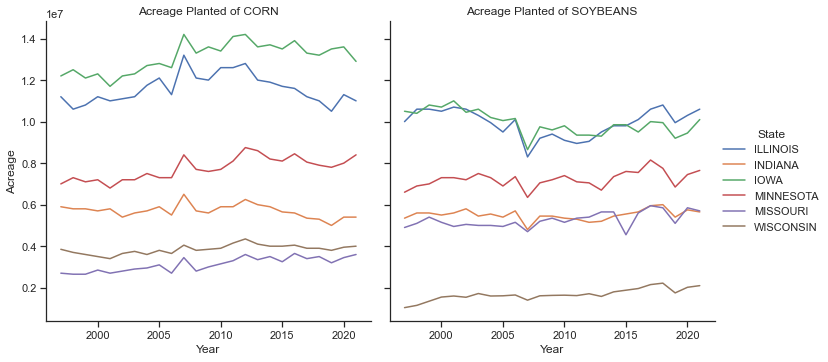

In [142]:
sns.set_theme(style="ticks")
g = sns.relplot(data = acreage_corn_soy,
            x = "Year", y = "Value", hue = "State",
            col = "Commodity", kind = "line")

(g.set_axis_labels("Year", "Acreage")
  .set_titles("Acreage Planted of {col_name}"))

## Net Cash Farm Income of Producers across States in 2017

### Analysis

In [164]:
income_2017_raw = pd.read_csv("../Data/Farmer Income/Net_Cash_Farm_Income_for_Producers_2017_Midwest_States.csv", thousands=',')

In [165]:
income_2017_raw.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,CENSUS,2017,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,"INCOME, NET CASH FARM","INCOME, NET CASH FARM, OF PRODUCERS - NET INCO...",AREA OPERATED,"AREA OPERATED: (1,000 TO 1,999 ACRES)",1077804000,2.7
1,CENSUS,2017,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,"INCOME, NET CASH FARM","INCOME, NET CASH FARM, OF PRODUCERS - NET INCO...",AREA OPERATED,AREA OPERATED: (1.0 TO 9.9 ACRES),21682000,49.4
2,CENSUS,2017,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,"INCOME, NET CASH FARM","INCOME, NET CASH FARM, OF PRODUCERS - NET INCO...",AREA OPERATED,AREA OPERATED: (10.0 TO 49.9 ACRES),147699000,9.2
3,CENSUS,2017,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,"INCOME, NET CASH FARM","INCOME, NET CASH FARM, OF PRODUCERS - NET INCO...",AREA OPERATED,AREA OPERATED: (100 TO 139 ACRES),78344000,9.8
4,CENSUS,2017,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,"INCOME, NET CASH FARM","INCOME, NET CASH FARM, OF PRODUCERS - NET INCO...",AREA OPERATED,AREA OPERATED: (140 TO 179 ACRES),77056000,13.3


Adding a new column to bucket the area operated of the farm

In [166]:
income_2017_raw['Area Bucket'] = np.select(
    [
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (1.0 TO 9.9 ACRES)', 
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (10.0 TO 49.9 ACRES)',
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (50.0 TO 69.9 ACRES)',
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (70.0 TO 99.9 ACRES)',
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (100 TO 139 ACRES)',
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (140 TO 179 ACRES)',
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (180 TO 219 ACRES)',
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (220 TO 259 ACRES)',
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (260 TO 499 ACRES)',
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (500 TO 999 ACRES)',
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (1,000 TO 1,999 ACRES)',
        income_2017_raw['Domain Category'] == 'AREA OPERATED: (2,000 OR MORE ACRES)'
    ], 
    [
        1, 
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12
    ]
)

In [167]:
income_2017_raw["Area Bucket"].unique()

array([11,  1,  2,  5,  6,  7, 12,  8,  9,  3, 10,  4])

Retaining only essential columns

In [168]:
income_2017 = income_2017_raw[["State", "State ANSI", "Domain Category", "Area Bucket", "Value"]]

In [169]:
income_2017.head()

,State,State ANSI,Domain Category,Area Bucket,Value
0,ILLINOIS,17,"AREA OPERATED: (1,000 TO 1,999 ACRES)",11,1077804000
1,ILLINOIS,17,AREA OPERATED: (1.0 TO 9.9 ACRES),1,21682000
2,ILLINOIS,17,AREA OPERATED: (10.0 TO 49.9 ACRES),2,147699000
3,ILLINOIS,17,AREA OPERATED: (100 TO 139 ACRES),5,78344000
4,ILLINOIS,17,AREA OPERATED: (140 TO 179 ACRES),6,77056000


Aggregating State-wise Net Cash Farm Income per State

In [278]:
state_agg_income_2017 = income_2017.groupby(['State']).agg(Farm_Income = ("Value", sum))

In [280]:
state_agg_income_2017['Farm_Income'] = state_agg_income_2017['Farm_Income'].apply(lambda x: "${:.2f} B".format((x/1000000000)))

### Results and Clarifications

In [281]:
state_agg_income_2017.head(10).sort_values(by=["Farm_Income"])

,Farm_Income
State,
MISSOURI,$1.95 B
INDIANA,$2.14 B
WISCONSIN,$2.28 B
MINNESOTA,$3.90 B
ILLINOIS,$4.17 B
IOWA,$6.04 B


ERS Data for Net Cash Farm Income for the above 6 states in 2017 (from NCFI data: https://data.ers.usda.gov/reports.aspx?ID=17831)

State | NCFI
---|---
Missouri|\$2.34 B
Indiana|\$2.83 B
Wisconsin|\$2.84 B
Minnesota|\$4.66 B
Illinois|\$3.63 B
Iowa|\$6.14 B

**Clarification from the Farm Income Team on the above discrepancy:**

**USDA/ERS and USDA/NASS use different data sources and methods to estimate NCFI.** The 2017 NASS NCFI estimates are based on the Census results primarily, that is, these are farmer-reported data (adjusted for coverage, since the response rate is less than 100%).  Farmers may over or under-report on certain aspects of their farm (like government payments received), although perhaps not deliberately. 
 
Our (ERS) estimates are based on a wide variety of sources – including both surveys (like NASS) and administrative data sources.  For example, our government payments data is based on administrative data from USDA on payments sent to farmers. Also, while Census asks farmers to report cash receipts (or sales), we (ERS) calculate cash receipts for many storable commodities (like corn, soybeans) using data on production, prices and marketing patterns. 
 
There should not be any major conceptual difference in the NASS / Census and ERS NCFI estimates, and the values from the two sources are similar

ERS Dashboard (https://www.ers.usda.gov/data-products/farm-income-and-wealth-statistics/charts-and-maps-about-your-state/) captures Net Farm Income for the above 6 states in 2017 as below:

State | Net Farm Income
---|---
Missouri|\$1.67 B
Indiana|\$1.66 B
Wisconsin|\$1.84 B
Minnesota|\$2.27 B
Illinois|\$2.24 B
Iowa|\$3.64 B

**Clarification from the Farm Income Team on the above discrepancy:**

It would be incorrect to assume that NFI simply includes NCFI, because of the differences in product sale timing assumed for the two measures. Specifically:
 
**Net cash farm income (NCFI)** is calculated as gross cash income minus cash expenses as follows:

$$ NCFI = \textit{Gross Cash Income} - \textit{Gross Production Expenses}$$
$$ = (\textit{Cash Receipts} + \textit{Direct Government Payments} + \textit{Cash Farm Related Income}) - \textit{Gross Production Expenses} $$
 
**Net farm income (NFI)** is a broader measure of profitability than net cash farm income (NCFI) since it incorporates noncash items, including changes in inventories, economic depreciation, and gross imputed rental income:

$$ NFI = \textit{Value of Crop and Animal Products} + \textit{Farm Related Income} + \textit{Direct Government Payments} - \textit{Production Expenses}$$

**The value of crop and animal/animal product production is different from cash receipts in that it reflects production in the year the products were produced rather than in the year in which they were sold.** 

NFI also accounts for the value of agricultural products consumed on the farm, as well as non-cash farm-related income and non-cash production expenses. Specifically, it includes the gross imputed rental value of farm dwellings as part of farm-related income. It also includes expenses associated with operator dwellings, non-cash employee compensation, and a measure of economic depreciation (capital consumption).

Additional clarifications in the FAQ [here](https://www.ers.usda.gov/data-products/farm-income-and-wealth-statistics/update-and-revision-history/faqs/#q14)

## Net Cash Farm Income per Acre across Farm operations of difference sizes

### Analysis

In [178]:
area_oper_2017_raw = pd.read_csv("../Data/Total_Area_Operated_2017_Midwest States_By_Area_Operated.csv", thousands=',')

In [182]:
area_oper_2017_raw.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%),Area Bucket
0,CENSUS,2017,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - ACRES OPERATED,AREA OPERATED,"AREA OPERATED: (1,000 TO 1,999 ACRES)",7060718,1.6,11
1,CENSUS,2017,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - ACRES OPERATED,AREA OPERATED,AREA OPERATED: (1.0 TO 9.9 ACRES),40961,14.0,1
2,CENSUS,2017,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - ACRES OPERATED,AREA OPERATED,AREA OPERATED: (10.0 TO 49.9 ACRES),463495,3.6,2
3,CENSUS,2017,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - ACRES OPERATED,AREA OPERATED,AREA OPERATED: (100 TO 139 ACRES),561643,6.1,5
4,CENSUS,2017,YEAR,NaN,STATE,ILLINOIS,17,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - ACRES OPERATED,AREA OPERATED,AREA OPERATED: (140 TO 179 ACRES),604265,5.4,6


In [179]:
area_oper_2017_raw["Domain Category"].unique()

array(['AREA OPERATED: (1,000 TO 1,999 ACRES)',
       'AREA OPERATED: (1.0 TO 9.9 ACRES)',
       'AREA OPERATED: (10.0 TO 49.9 ACRES)',
       'AREA OPERATED: (100 TO 139 ACRES)',
       'AREA OPERATED: (140 TO 179 ACRES)',
       'AREA OPERATED: (180 TO 219 ACRES)',
       'AREA OPERATED: (2,000 OR MORE ACRES)',
       'AREA OPERATED: (2,000 TO 4,999 ACRES)',
       'AREA OPERATED: (220 TO 259 ACRES)',
       'AREA OPERATED: (260 TO 499 ACRES)',
       'AREA OPERATED: (5,000 OR MORE ACRES)',
       'AREA OPERATED: (50.0 TO 69.9 ACRES)',
       'AREA OPERATED: (500 TO 999 ACRES)',
       'AREA OPERATED: (70.0 TO 99.9 ACRES)'], dtype=object)

Adding a new column to bucket the area operated of the farm

In [180]:
area_oper_2017_raw['Area Bucket'] = np.select(
    [
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (1.0 TO 9.9 ACRES)', 
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (10.0 TO 49.9 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (50.0 TO 69.9 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (70.0 TO 99.9 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (100 TO 139 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (140 TO 179 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (180 TO 219 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (220 TO 259 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (260 TO 499 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (500 TO 999 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (1,000 TO 1,999 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (2,000 OR MORE ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (2,000 TO 4,999 ACRES)',
        area_oper_2017_raw['Domain Category'] == 'AREA OPERATED: (5,000 OR MORE ACRES)'
    ], 
    [
        1, 
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14
    ]
)

In [181]:
area_oper_2017_raw["Area Bucket"].unique()

array([11,  1,  2,  5,  6,  7, 12, 13,  8,  9, 14,  3, 10,  4])

In [183]:
area_oper_2017 = area_oper_2017_raw[["State", "State ANSI", "Domain Category", "Area Bucket", "Value"]]

Dropping the rows with `Area Bucket` = 13 and 14, since those buckets are absent in the income dataframe

In [198]:
area_oper_2017 = area_oper_2017[area_oper_2017["Area Bucket"].isin([ab for ab in range(1,13)])]

Verifying if Income and Area dataframes are ready for merge

In [204]:
area_oper_2017.shape[0] == income_2017.shape[0]

True

In [206]:
income_2017.groupby(['Area Bucket']).agg(Farm_Income = ("Value", len))

,Farm_Income
Area Bucket,
1,6
2,6
3,6
4,6
5,6
6,6
7,6
8,6
9,6


In [207]:
area_oper_2017.groupby(['Area Bucket']).agg(Farm_Income = ("Value", len))

,Farm_Income
Area Bucket,
1,6
2,6
3,6
4,6
5,6
6,6
7,6
8,6
9,6


In [211]:
# Merging Income and Area dataframes
income_area_2017 = pd.merge(income_2017, area_oper_2017, on=["State", "State ANSI", "Area Bucket"])

Retaining just one `Domain Category` column, and renaming `Value_x` to `Income` and `Value_y` to `Area Operated`

In [224]:
income_area_2017 = income_area_2017.drop(columns = ["Domain Category_y"])
income_area_2017 = income_area_2017.rename(columns={"Domain Category_x": "Domain Category", "Value_x": "Income", "Value_y": "Area Operated"})

Adding a new column for Income per Acre

In [225]:
income_area_2017["Income per Acre"] = income_area_2017["Income"]/income_area_2017["Area Operated"]

In [226]:
income_area_2017.head()

,State,State ANSI,Domain Category,Area Bucket,Income,Area Operated,Income per Acre
0,ILLINOIS,17,"AREA OPERATED: (1,000 TO 1,999 ACRES)",11,1077804000,7060718,152.647932
1,ILLINOIS,17,AREA OPERATED: (1.0 TO 9.9 ACRES),1,21682000,40961,529.332780
2,ILLINOIS,17,AREA OPERATED: (10.0 TO 49.9 ACRES),2,147699000,463495,318.663632
3,ILLINOIS,17,AREA OPERATED: (100 TO 139 ACRES),5,78344000,561643,139.490744
4,ILLINOIS,17,AREA OPERATED: (140 TO 179 ACRES),6,77056000,604265,127.520211


### Result/Visualization

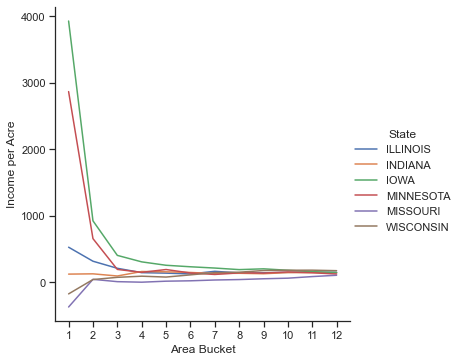

In [228]:
sns.set_theme(style="ticks")
g = sns.relplot(data = income_area_2017,
            x = "Area Bucket", y = "Income per Acre", hue = "State", kind = "line")
plt.xticks([ab for ab in range(1,13)])
(g.set_axis_labels("Area Bucket", "Income per Acre")
  .set_titles("Income per Acre across Farm Operations of Increasing sizes"))

**Observations:**

1. We see that most of the differences in the Income/Acre across states is for the smaller farms that are less than 50 Acres in Area Operated. For larger farms, this value seems to converge across states

2. We see that for Missouri and Wisconsin, Income/Acre is less than zero for the smaller farms (potentially indicating losses), whereas for Iowa and Minnessota, it takes on very high values. **As next steps it will be interesting to understand the crops grown in these small farms in these states to see if the crop type is influencing such differences in Income/Acre**

## Number of Farm Operations across counties

### Analysis

In [243]:
farm_oper_2017_raw = pd.read_csv("../Data/Farm_Operations_2017_Midwest_States_By County_By_Area_Operated.csv", thousands=',', dtype={'State ANSI': object, 'County ANSI': object})

# dtype is used to retain State and County codes with starting zeros as is, instead of reading them as integers

In [244]:
farm_oper_2017_raw.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,039,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,AREA OPERATED,"AREA OPERATED: (1,000 OR MORE ACRES)",63,21.2
1,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,039,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,AREA OPERATED,"AREA OPERATED: (1,000 TO 1,999 ACRES)",46,26.1
2,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,039,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,AREA OPERATED,AREA OPERATED: (1.0 TO 9.9 ACRES),81,67.9
3,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,039,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,AREA OPERATED,AREA OPERATED: (10.0 TO 49.9 ACRES),144,28.5
4,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,039,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,AREA OPERATED,AREA OPERATED: (100 TO 139 ACRES),31,37.4


Retaining only essential columns

In [245]:
farm_oper_2017 = farm_oper_2017_raw[["State", "State ANSI", "County", "County ANSI", "Value"]]

Aggregating at County Level

In [246]:
farm_oper_2017.head()

,State,State ANSI,County,County ANSI,Value
0,ILLINOIS,17,DE WITT,039,63
1,ILLINOIS,17,DE WITT,039,46
2,ILLINOIS,17,DE WITT,039,81
3,ILLINOIS,17,DE WITT,039,144
4,ILLINOIS,17,DE WITT,039,31


In [260]:
county_agg_farm_oper_2017 = farm_oper_2017.groupby(['State','State ANSI','County','County ANSI']).agg(Farms = ("Value", sum)).reset_index()

Creating a FIPS_Code column to match up with county level spatial data

In [261]:
county_agg_farm_oper_2017["FIPS_code"] = county_agg_farm_oper_2017["State ANSI"] + county_agg_farm_oper_2017["County ANSI"]

In [262]:
county_agg_farm_oper_2017.head()

,State,State ANSI,County,County ANSI,Farms,FIPS_code
0,ILLINOIS,17,ADAMS,001,2113,17001
1,ILLINOIS,17,ALEXANDER,003,203,17003
2,ILLINOIS,17,BOND,005,933,17005
3,ILLINOIS,17,BOONE,007,621,17007
4,ILLINOIS,17,BROWN,009,684,17009


Retaining just the Number of farms per county (FIPS_Code)

In [263]:
fips_agg_farm_oper_2017 = county_agg_farm_oper_2017[["FIPS_code", "Farms"]]

In [264]:
fips_agg_farm_oper_2017.head()

,FIPS_code,Farms
0,17001,2113
1,17003,203
2,17005,933
3,17007,621
4,17009,684


### Result/Visualization

(<Figure size 1000x700 with 2 Axes>,
 <AxesSubplot:title={'center':'Number of Farm Operations by county'}>)

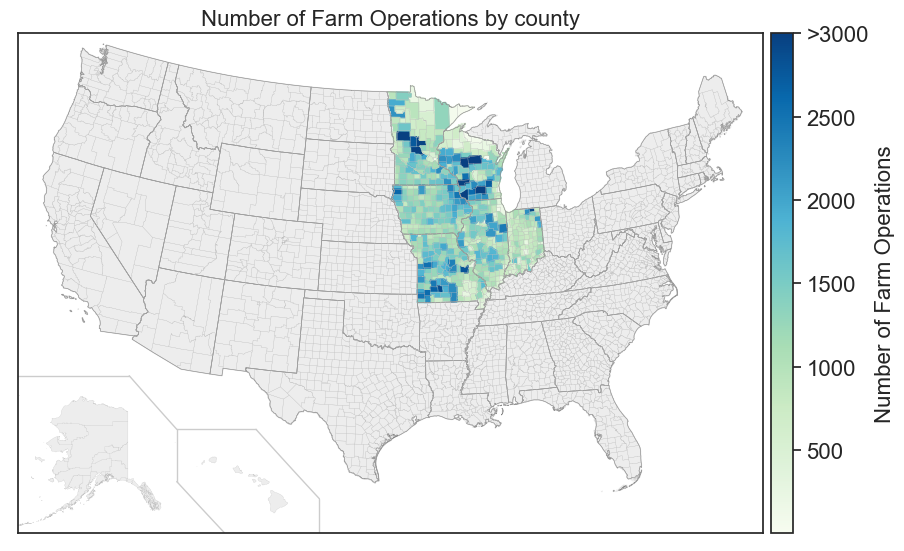

In [267]:
pu.choropleth_map_county(
    fips_agg_farm_oper_2017,
    map_title='Number of Farm Operations by county',
    unit='Number of Farm Operations',
    vmax=3000, dpi=100, fontsize=16,cmap='GnBu',
)

## a. Change in number of Farm Operations by Farm Size (2012 vs 2017)

### Analysis

In [1]:
# Data Parameters used

source_desc = "CENSUS"
sector_desc = "ECONOMICS"
group_desc = "FARMS & LAND & ASSETS"
commodity_desc = "FARM OPERATIONS"
statisticcat_desc = "OPERATIONS"
short_desc = "FARM OPERATIONS - NUMBER OF OPERATIONS"
domain_desc = "AREA OPERATED"
agg_level_desc = "COUNTY"
state_name = ["ILLINOIS", "INDIANA", "IOWA", "MINNESOTA", "MISSOURI", "WISCONSIN"]
year = 2012 # and year = 2017
freq_desc = "ANNUAL"
reference_period_desc = "YEAR"
# format = "JSON"

In [94]:
farm_oper_by_size_2012_2017_raw = pd.read_csv("../Data/FarmOperations_2012_2017_byCounty_bySize.csv", thousands=',', dtype={'State ANSI': object, 'County ANSI': object})

In [95]:
farm_oper_by_size_2012_2017_raw.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,039,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,AREA OPERATED,"AREA OPERATED: (1,000 OR MORE ACRES)",63,21.2
1,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,039,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,AREA OPERATED,"AREA OPERATED: (1,000 TO 1,999 ACRES)",46,26.1
2,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,039,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,AREA OPERATED,AREA OPERATED: (1.0 TO 9.9 ACRES),81,67.9
3,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,039,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,AREA OPERATED,AREA OPERATED: (10.0 TO 49.9 ACRES),144,28.5
4,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,039,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - NUMBER OF OPERATIONS,AREA OPERATED,AREA OPERATED: (100 TO 139 ACRES),31,37.4


Checking if the Farm size buckets are same for both Census years 2012 and 2017

In [96]:
farm_oper_by_size_2012_2017_raw[farm_oper_by_size_2012_2017_raw["Year"] == 2012]["Domain Category"].unique()

array(['AREA OPERATED: (1,000 OR MORE ACRES)',
       'AREA OPERATED: (1,000 TO 1,999 ACRES)',
       'AREA OPERATED: (1.0 TO 9.9 ACRES)',
       'AREA OPERATED: (10.0 TO 49.9 ACRES)',
       'AREA OPERATED: (100 TO 139 ACRES)',
       'AREA OPERATED: (140 TO 179 ACRES)',
       'AREA OPERATED: (180 TO 219 ACRES)',
       'AREA OPERATED: (180 TO 499 ACRES)',
       'AREA OPERATED: (2,000 OR MORE ACRES)',
       'AREA OPERATED: (220 TO 259 ACRES)',
       'AREA OPERATED: (260 TO 499 ACRES)',
       'AREA OPERATED: (50 TO 179 ACRES)',
       'AREA OPERATED: (50.0 TO 69.9 ACRES)',
       'AREA OPERATED: (500 TO 999 ACRES)',
       'AREA OPERATED: (70.0 TO 99.9 ACRES)'], dtype=object)

In [97]:
farm_oper_by_size_2012_2017_raw[farm_oper_by_size_2012_2017_raw["Year"] == 2017]["Domain Category"].unique()

array(['AREA OPERATED: (1,000 OR MORE ACRES)',
       'AREA OPERATED: (1,000 TO 1,999 ACRES)',
       'AREA OPERATED: (1.0 TO 9.9 ACRES)',
       'AREA OPERATED: (10.0 TO 49.9 ACRES)',
       'AREA OPERATED: (100 TO 139 ACRES)',
       'AREA OPERATED: (140 TO 179 ACRES)',
       'AREA OPERATED: (180 TO 219 ACRES)',
       'AREA OPERATED: (180 TO 499 ACRES)',
       'AREA OPERATED: (2,000 OR MORE ACRES)',
       'AREA OPERATED: (220 TO 259 ACRES)',
       'AREA OPERATED: (260 TO 499 ACRES)',
       'AREA OPERATED: (50 TO 179 ACRES)',
       'AREA OPERATED: (50.0 TO 69.9 ACRES)',
       'AREA OPERATED: (500 TO 999 ACRES)',
       'AREA OPERATED: (70.0 TO 99.9 ACRES)'], dtype=object)

Adding a new column to bucket the area operated of the farm

In [98]:
farm_oper_by_size_2012_2017_raw['Area Bucket'] = np.select(
    [
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (1.0 TO 9.9 ACRES)', 
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (10.0 TO 49.9 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (50 TO 179 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (180 TO 499 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (500 TO 999 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (1,000 TO 1,999 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (2,000 OR MORE ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (50.0 TO 69.9 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (70.0 TO 99.9 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (100 TO 139 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (140 TO 179 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (180 TO 219 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (220 TO 259 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (260 TO 499 ACRES)',
        farm_oper_by_size_2012_2017_raw['Domain Category'] == 'AREA OPERATED: (1,000 OR MORE ACRES)'

    ], 
    [
        1, 
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15
    ]
)

In [99]:
farm_oper_by_size_2012_2017_raw["Area Bucket"].unique()

array([15,  6,  1,  2, 10, 11, 12,  4,  7, 13, 14,  3,  8,  5,  9])

Retaining only essential columns

In [100]:
farm_oper_by_size_2012_2017 = farm_oper_by_size_2012_2017_raw[["State", "State ANSI", "County", "County ANSI", "Year", "Domain Category", "Area Bucket", "Value"]]

In [101]:
farm_oper_by_size_2012_2017.head()

,State,State ANSI,County,County ANSI,Year,Domain Category,Area Bucket,Value
0,ILLINOIS,17,DE WITT,039,2017,"AREA OPERATED: (1,000 OR MORE ACRES)",15,63
1,ILLINOIS,17,DE WITT,039,2017,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,46
2,ILLINOIS,17,DE WITT,039,2017,AREA OPERATED: (1.0 TO 9.9 ACRES),1,81
3,ILLINOIS,17,DE WITT,039,2017,AREA OPERATED: (10.0 TO 49.9 ACRES),2,144
4,ILLINOIS,17,DE WITT,039,2017,AREA OPERATED: (100 TO 139 ACRES),10,31


Retaining only the rows with `Area Bucket` from 1 to 7 and dropping other more granular buckets

In [102]:
farm_oper_by_size_2012_2017 = farm_oper_by_size_2012_2017[farm_oper_by_size_2012_2017["Area Bucket"].isin([ab for ab in range(1,8)])]

In [103]:
farm_oper_by_size_2012_2017.head()

,State,State ANSI,County,County ANSI,Year,Domain Category,Area Bucket,Value
1,ILLINOIS,17,DE WITT,039,2017,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,46
2,ILLINOIS,17,DE WITT,039,2017,AREA OPERATED: (1.0 TO 9.9 ACRES),1,81
3,ILLINOIS,17,DE WITT,039,2017,AREA OPERATED: (10.0 TO 49.9 ACRES),2,144
7,ILLINOIS,17,DE WITT,039,2017,AREA OPERATED: (180 TO 499 ACRES),4,72
8,ILLINOIS,17,DE WITT,039,2017,"AREA OPERATED: (2,000 OR MORE ACRES)",7,17


Creating a FIPS_Code column to match up with county level spatial data

In [104]:
farm_oper_by_size_2012_2017["FIPS_code"] = farm_oper_by_size_2012_2017["State ANSI"] + farm_oper_by_size_2012_2017["County ANSI"]

In [105]:
farm_oper_by_size_2012_2017 = farm_oper_by_size_2012_2017.drop(columns = ["State ANSI", "County ANSI"])

In [106]:
farm_oper_by_size_2012_2017.shape

(7860, 7)

In [107]:
farm_oper_by_size_2012_2017_pivot = pd.pivot_table(farm_oper_by_size_2012_2017, values='Value', index=['State', 'County', 'FIPS_code', 'Domain Category', 'Area Bucket'], columns=['Year'], aggfunc=np.sum).reset_index()

In [108]:
farm_oper_by_size_2012_2017_pivot[farm_oper_by_size_2012_2017_pivot[2017].isna()]

Year,State,County,FIPS_code,Domain Category,Area Bucket,2012,2017
149,ILLINOIS,DU PAGE,17043,"AREA OPERATED: (2,000 OR MORE ACRES)",7,1.0,NaN
237,ILLINOIS,HARDIN,17069,AREA OPERATED: (1.0 TO 9.9 ACRES),1,1.0,NaN
757,INDIANA,BROWN,18013,"AREA OPERATED: (2,000 OR MORE ACRES)",7,1.0,NaN
1078,INDIANA,MONROE,18105,"AREA OPERATED: (2,000 OR MORE ACRES)",7,2.0,NaN
1248,INDIANA,SWITZERLAND,18155,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,2.0,NaN
2154,MINNESOTA,COOK,27031,AREA OPERATED: (500 TO 999 ACRES),5,1.0,NaN
2166,MINNESOTA,CROW WING,27035,"AREA OPERATED: (2,000 OR MORE ACRES)",7,1.0,NaN
3426,MISSOURI,WEBSTER,29225,"AREA OPERATED: (2,000 OR MORE ACRES)",7,4.0,NaN
3714,WISCONSIN,MENOMINEE,55078,AREA OPERATED: (10.0 TO 49.9 ACRES),2,1.0,NaN
3715,WISCONSIN,MENOMINEE,55078,AREA OPERATED: (180 TO 499 ACRES),4,2.0,NaN


In [109]:
len(farm_oper_by_size_2012_2017_pivot[farm_oper_by_size_2012_2017_pivot[2017].isna()])

12

In [110]:
farm_oper_by_size_2012_2017_pivot[farm_oper_by_size_2012_2017_pivot[2012].isna()]

Year,State,County,FIPS_code,Domain Category,Area Bucket,2012,2017
795,INDIANA,CRAWFORD,18025,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,NaN,2.0
2150,MINNESOTA,COOK,27031,AREA OPERATED: (1.0 TO 9.9 ACRES),1,NaN,12.0
3237,MISSOURI,PULASKI,29169,"AREA OPERATED: (2,000 OR MORE ACRES)",7,NaN,2.0
3573,WISCONSIN,FLORENCE,55037,AREA OPERATED: (500 TO 999 ACRES),5,NaN,7.0
3616,WISCONSIN,IRON,55051,AREA OPERATED: (1.0 TO 9.9 ACRES),1,NaN,1.0
3716,WISCONSIN,MENOMINEE,55078,AREA OPERATED: (50 TO 179 ACRES),3,NaN,2.0


In [111]:
len(farm_oper_by_size_2012_2017_pivot[farm_oper_by_size_2012_2017_pivot[2012].isna()])

6

In [112]:
farm_oper_by_size_2012_2017_pivot.shape

(3939, 7)

In [113]:
(3939*2)-(12+6)

7860

The pivot table has been done correctly

Replacing all NaN with 0, since it indicates no farms in that particular year for that Farm Size in that county

In [114]:
farm_oper_by_size_2012_2017_pivot = farm_oper_by_size_2012_2017_pivot.fillna(0)

In [115]:
len(farm_oper_by_size_2012_2017_pivot[farm_oper_by_size_2012_2017_pivot[2012].isna()])

0

In [116]:
len(farm_oper_by_size_2012_2017_pivot[farm_oper_by_size_2012_2017_pivot[2017].isna()])

0

Aggregating at State-Farm Size Level after dropping other granular columns

In [117]:
farm_oper_by_size_2012_2017_pivot = farm_oper_by_size_2012_2017_pivot.drop(columns = ["County", "FIPS_code"])

In [118]:
state_agg_farm_oper_by_size_2012_2017_pivot = farm_oper_by_size_2012_2017_pivot.groupby(['State','Domain Category','Area Bucket']).agg({2012:'sum', 2017:'sum'}).reset_index()

In [119]:
state_agg_farm_oper_by_size_2012_2017_pivot.head(20)

Year,State,Domain Category,Area Bucket,2012,2017
0,ILLINOIS,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,5267.0,5155.0
1,ILLINOIS,AREA OPERATED: (1.0 TO 9.9 ACRES),1,5776.0,7992.0
2,ILLINOIS,AREA OPERATED: (10.0 TO 49.9 ACRES),2,19801.0,17901.0
3,ILLINOIS,AREA OPERATED: (180 TO 499 ACRES),4,13216.0,12264.0
4,ILLINOIS,"AREA OPERATED: (2,000 OR MORE ACRES)",7,2469.0,2658.0
5,ILLINOIS,AREA OPERATED: (50 TO 179 ACRES),3,20941.0,19198.0
6,ILLINOIS,AREA OPERATED: (500 TO 999 ACRES),5,7617.0,7483.0
7,INDIANA,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,2544.0,2585.0
8,INDIANA,AREA OPERATED: (1.0 TO 9.9 ACRES),1,6607.0,7622.0
9,INDIANA,AREA OPERATED: (10.0 TO 49.9 ACRES),2,20770.0,18665.0


In [120]:
state_agg_farm_oper_by_size_2012_2017_pivot["Change"] = state_agg_farm_oper_by_size_2012_2017_pivot[2017] - state_agg_farm_oper_by_size_2012_2017_pivot[2012]

In [121]:
state_agg_farm_oper_by_size_2012_2017_pivot["Perc_Change"] = (state_agg_farm_oper_by_size_2012_2017_pivot["Change"]/state_agg_farm_oper_by_size_2012_2017_pivot[2012])*100

Overall change in the number of Farm Operations from 2012 to 2017 in the 6 States considered

In [122]:
state_agg_farm_oper_by_size_2012_2017_pivot[2017].sum() - state_agg_farm_oper_by_size_2012_2017_pivot[2012].sum()

-21547.0

Overall the number of Farm Operations have decreased in these states by a number of 21.5K

In [123]:
IL_change_in_farm_oper_by_size = state_agg_farm_oper_by_size_2012_2017_pivot[state_agg_farm_oper_by_size_2012_2017_pivot["State"] == "ILLINOIS"]

In [124]:
IL_change_in_farm_oper_by_size.sort_values(by = 'Area Bucket')

Year,State,Domain Category,Area Bucket,2012,2017,Change,Perc_Change
1,ILLINOIS,AREA OPERATED: (1.0 TO 9.9 ACRES),1,5776.0,7992.0,2216.0,38.365651
2,ILLINOIS,AREA OPERATED: (10.0 TO 49.9 ACRES),2,19801.0,17901.0,-1900.0,-9.595475
5,ILLINOIS,AREA OPERATED: (50 TO 179 ACRES),3,20941.0,19198.0,-1743.0,-8.323385
3,ILLINOIS,AREA OPERATED: (180 TO 499 ACRES),4,13216.0,12264.0,-952.0,-7.203390
6,ILLINOIS,AREA OPERATED: (500 TO 999 ACRES),5,7617.0,7483.0,-134.0,-1.759223
0,ILLINOIS,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,5267.0,5155.0,-112.0,-2.126448
4,ILLINOIS,"AREA OPERATED: (2,000 OR MORE ACRES)",7,2469.0,2658.0,189.0,7.654921


### Result/Visualization

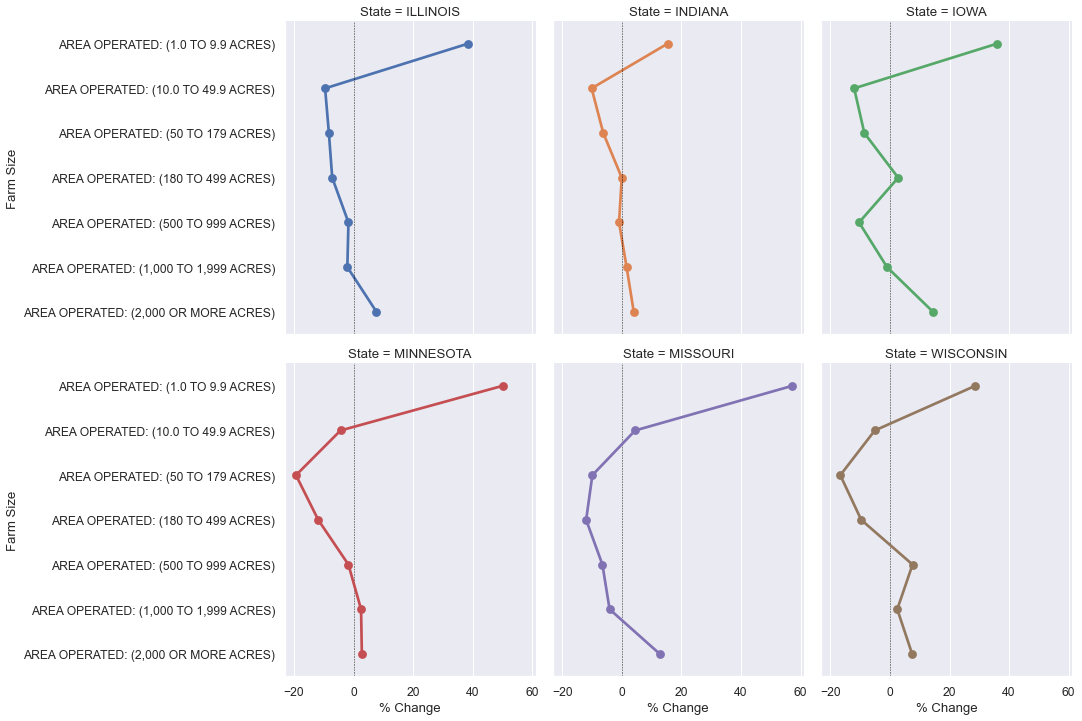

In [227]:
sns.set_theme(style="ticks")
sns.set(font_scale = 1.1)
g = sns.catplot(data = state_agg_farm_oper_by_size_2012_2017_pivot,
                x = "Perc_Change", y = "Domain Category",
                order = ['AREA OPERATED: (1.0 TO 9.9 ACRES)',
                         'AREA OPERATED: (10.0 TO 49.9 ACRES)',
                         'AREA OPERATED: (50 TO 179 ACRES)',
                         'AREA OPERATED: (180 TO 499 ACRES)',
                         'AREA OPERATED: (500 TO 999 ACRES)',
                         'AREA OPERATED: (1,000 TO 1,999 ACRES)',
                         'AREA OPERATED: (2,000 OR MORE ACRES)'],
                col = "State", col_wrap=3,hue = "State",
                xlim=(-20, 60), kind = "point")

(g.set_axis_labels("% Change", "Farm Size"))

line_position = [0]*6
for ax, pos in zip(g.axes.flat, line_position):
    ax.axvline(0, color = "black", linewidth = 0.5, linestyle = "--")

plt.show()

## b. Change in the area of Farm Operations by Farm Size (2012 vs 2017)

### Analysis

In [1]:
# Data Parameters used

source_desc = "CENSUS"
sector_desc = "ECONOMICS"
group_desc = "FARMS & LAND & ASSETS"
commodity_desc = "FARM OPERATIONS"
statisticcat_desc = "OPERATIONS"
short_desc = "FARM OPERATIONS - ACRES OPERATED"
domain_desc = "AREA OPERATED"
agg_level_desc = "COUNTY"
state_name = ["ILLINOIS", "INDIANA", "IOWA", "MINNESOTA", "MISSOURI", "WISCONSIN"]
year = 2012 # and year = 2017
freq_desc = "ANNUAL"
reference_period_desc = "YEAR"
# format = "JSON"

In [2]:
area_oper_by_size_2012_2017_raw = pd.read_csv("../Data/AreaOperated_2012_2017_byCounty_bySize.csv", thousands = ',' ,dtype={'State ANSI': object, 'County ANSI': object})

In [21]:
area_oper_by_size_2012_2017_raw.shape

(13476, 21)

In [3]:
area_oper_by_size_2012_2017_raw['Value'][0]

'60,231'

In [11]:
area_oper_by_size_2012_2017_raw['Value'].sort_values()

846         (D)
5690        (D)
5685        (D)
5631        (D)
11937       (D)
          ...  
4294     99,925
409         993
12868       993
4351        993
6414        996
Name: Value, Length: 13476, dtype: object

Due to the presence of rows with ` (D)` in the `Value` column, the column is being identified as string. We'll check the proportion of such rows in the dataset, and if it is negligible, we will remove them

In [15]:
len(area_oper_by_size_2012_2017_raw[area_oper_by_size_2012_2017_raw['Value'] == " (D)"])/area_oper_by_size_2012_2017_raw.shape[0]

0.02122291481151677

In [18]:
area_oper_by_size_2012_2017_raw[area_oper_by_size_2012_2017_raw['Value'] == " (D)"].groupby(['State','County','Year','Domain Category']).agg(Count = ("Value", len))

Count
State     County    Year Domain Category                           
ILLINOIS  ALEXANDER 2017 AREA OPERATED: (1.0 TO 9.9 ACRES)        1
                         AREA OPERATED: (140 TO 179 ACRES)        1
                         AREA OPERATED: (220 TO 259 ACRES)        1
          COOK      2012 AREA OPERATED: (140 TO 179 ACRES)        1
                         AREA OPERATED: (180 TO 219 ACRES)        1
...                                                             ...
WISCONSIN VILAS     2017 AREA OPERATED: (100 TO 139 ACRES)        1
                         AREA OPERATED: (180 TO 219 ACRES)        1
                         AREA OPERATED: (260 TO 499 ACRES)        1
                         AREA OPERATED: (500 TO 999 ACRES)        1
                         AREA OPERATED: (70.0 TO 99.9 ACRES)      1

[286 rows x 1 columns]

Given they are only 2.1% of the dataset, and that these seem to be random rows spread across different states, counties, years and Domain Category (meaning, no systematic data error) we will remove these rows

In [19]:
area_oper_by_size_2012_2017_clean = area_oper_by_size_2012_2017_raw[area_oper_by_size_2012_2017_raw['Value'] != " (D)"]

In [20]:
area_oper_by_size_2012_2017_clean.shape

(13190, 21)

In [22]:
area_oper_by_size_2012_2017_clean.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,...,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - ACRES OPERATED,AREA OPERATED,"AREA OPERATED: (1,000 TO 1,999 ACRES)","60,231",26.5
1,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,...,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - ACRES OPERATED,AREA OPERATED,AREA OPERATED: (1.0 TO 9.9 ACRES),379,74.2
2,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,...,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - ACRES OPERATED,AREA OPERATED,AREA OPERATED: (10.0 TO 49.9 ACRES),"3,816",28.3
3,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,...,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - ACRES OPERATED,AREA OPERATED,AREA OPERATED: (100 TO 139 ACRES),"3,644",36.9
4,CENSUS,2017,YEAR,NaN,COUNTY,ILLINOIS,17,CENTRAL,40,DE WITT,...,NaN,NaN,0,NaN,FARM OPERATIONS,FARM OPERATIONS - ACRES OPERATED,AREA OPERATED,AREA OPERATED: (140 TO 179 ACRES),"1,992",38.0


Converting the value column from string to float

In [23]:
area_oper_by_size_2012_2017_clean['Value'] = area_oper_by_size_2012_2017_clean['Value'].str.replace(',', '').astype(float)

In [27]:
area_oper_by_size_2012_2017_clean['Value'].sort_values()

3878          5.0
12273         9.0
11122         9.0
12177         9.0
12357        11.0
           ...   
10659    346119.0
10707    399349.0
3964     498490.0
4000     555884.0
10743    597556.0
Name: Value, Length: 13190, dtype: float64

Checking if the Farm size buckets are same for both Census years 2012 and 2017

In [28]:
area_oper_by_size_2012_2017_clean[area_oper_by_size_2012_2017_clean["Year"] == 2012]["Domain Category"].unique()

array(['AREA OPERATED: (1,000 TO 1,999 ACRES)',
       'AREA OPERATED: (1.0 TO 9.9 ACRES)',
       'AREA OPERATED: (10.0 TO 49.9 ACRES)',
       'AREA OPERATED: (100 TO 139 ACRES)',
       'AREA OPERATED: (140 TO 179 ACRES)',
       'AREA OPERATED: (180 TO 219 ACRES)',
       'AREA OPERATED: (2,000 OR MORE ACRES)',
       'AREA OPERATED: (220 TO 259 ACRES)',
       'AREA OPERATED: (260 TO 499 ACRES)',
       'AREA OPERATED: (50.0 TO 69.9 ACRES)',
       'AREA OPERATED: (500 TO 999 ACRES)',
       'AREA OPERATED: (70.0 TO 99.9 ACRES)'], dtype=object)

In [29]:
area_oper_by_size_2012_2017_clean[area_oper_by_size_2012_2017_clean["Year"] == 2017]["Domain Category"].unique()

array(['AREA OPERATED: (1,000 TO 1,999 ACRES)',
       'AREA OPERATED: (1.0 TO 9.9 ACRES)',
       'AREA OPERATED: (10.0 TO 49.9 ACRES)',
       'AREA OPERATED: (100 TO 139 ACRES)',
       'AREA OPERATED: (140 TO 179 ACRES)',
       'AREA OPERATED: (180 TO 219 ACRES)',
       'AREA OPERATED: (2,000 OR MORE ACRES)',
       'AREA OPERATED: (220 TO 259 ACRES)',
       'AREA OPERATED: (260 TO 499 ACRES)',
       'AREA OPERATED: (50.0 TO 69.9 ACRES)',
       'AREA OPERATED: (500 TO 999 ACRES)',
       'AREA OPERATED: (70.0 TO 99.9 ACRES)'], dtype=object)

Adding a new column to bucket the area operated of the farm

In [30]:
area_oper_by_size_2012_2017_clean['Area Bucket'] = np.select(
    [
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (1.0 TO 9.9 ACRES)', 
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (10.0 TO 49.9 ACRES)',
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (50.0 TO 69.9 ACRES)',
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (70.0 TO 99.9 ACRES)',
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (100 TO 139 ACRES)',
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (140 TO 179 ACRES)',
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (180 TO 219 ACRES)',
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (220 TO 259 ACRES)',
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (260 TO 499 ACRES)',
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (500 TO 999 ACRES)',
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (1,000 TO 1,999 ACRES)',
        area_oper_by_size_2012_2017_clean['Domain Category'] == 'AREA OPERATED: (2,000 OR MORE ACRES)'
    ], 
    [
        1, 
        2,
        3,
        3,
        3,
        3,
        4,
        4,
        4,
        5,
        6,
        7
    ]
)

Here have assigned same area buckets for certain Domain Categories as to group them together later under one Domain Category

In [31]:
area_oper_by_size_2012_2017_clean["Area Bucket"].unique()

array([6, 1, 2, 3, 4, 7, 5])

Retaining only essential columns

In [32]:
area_oper_by_size_2012_2017 = area_oper_by_size_2012_2017_clean[["State", "State ANSI", "County", "County ANSI", "Year", "Area Bucket", "Value"]]

In [33]:
area_oper_by_size_2012_2017.head()

,State,State ANSI,County,County ANSI,Year,Area Bucket,Value
0,ILLINOIS,17,DE WITT,039,2017,6,60231.0
1,ILLINOIS,17,DE WITT,039,2017,1,379.0
2,ILLINOIS,17,DE WITT,039,2017,2,3816.0
3,ILLINOIS,17,DE WITT,039,2017,3,3644.0
4,ILLINOIS,17,DE WITT,039,2017,3,1992.0


Aggregating the `Value` column (corresponding to Area Operated) per Area Bucket

In [34]:
area_oper_by_grp_size_2012_2017 = area_oper_by_size_2012_2017.groupby(['State','State ANSI','County','County ANSI','Year','Area Bucket']).agg(AreaOper = ("Value", sum)).reset_index()

In [35]:
area_oper_by_grp_size_2012_2017.head(20)

,State,State ANSI,County,County ANSI,Year,Area Bucket,AreaOper
0,ILLINOIS,17,ADAMS,001,2012,1,420.0
1,ILLINOIS,17,ADAMS,001,2012,2,7415.0
2,ILLINOIS,17,ADAMS,001,2012,3,43821.0
3,ILLINOIS,17,ADAMS,001,2012,4,79885.0
4,ILLINOIS,17,ADAMS,001,2012,5,95813.0
5,ILLINOIS,17,ADAMS,001,2012,6,87182.0
6,ILLINOIS,17,ADAMS,001,2012,7,74211.0
7,ILLINOIS,17,ADAMS,001,2017,1,446.0
8,ILLINOIS,17,ADAMS,001,2017,2,7081.0
9,ILLINOIS,17,ADAMS,001,2017,3,41028.0


In [37]:
area_oper_by_grp_size_2012_2017['Farm Size'] = np.select(
    [
        area_oper_by_grp_size_2012_2017['Area Bucket'] == 1, 
        area_oper_by_grp_size_2012_2017['Area Bucket'] == 2,
        area_oper_by_grp_size_2012_2017['Area Bucket'] == 3,
        area_oper_by_grp_size_2012_2017['Area Bucket'] == 4,
        area_oper_by_grp_size_2012_2017['Area Bucket'] == 5,
        area_oper_by_grp_size_2012_2017['Area Bucket'] == 6,
        area_oper_by_grp_size_2012_2017['Area Bucket'] == 7,
    ], 
    [
        'AREA OPERATED: (1.0 TO 9.9 ACRES)',
        'AREA OPERATED: (10.0 TO 49.9 ACRES)',
        'AREA OPERATED: (50 TO 179 ACRES)',
        'AREA OPERATED: (180 TO 499 ACRES)',
        'AREA OPERATED: (500 TO 999 ACRES)',
        'AREA OPERATED: (1,000 TO 1,999 ACRES)',
        'AREA OPERATED: (2,000 OR MORE ACRES)'
    ]
)

In [38]:
area_oper_by_grp_size_2012_2017.head()

,State,State ANSI,County,County ANSI,Year,Area Bucket,AreaOper,Farm Size
0,ILLINOIS,17,ADAMS,001,2012,1,420.0,AREA OPERATED: (1.0 TO 9.9 ACRES)
1,ILLINOIS,17,ADAMS,001,2012,2,7415.0,AREA OPERATED: (10.0 TO 49.9 ACRES)
2,ILLINOIS,17,ADAMS,001,2012,3,43821.0,AREA OPERATED: (50 TO 179 ACRES)
3,ILLINOIS,17,ADAMS,001,2012,4,79885.0,AREA OPERATED: (180 TO 499 ACRES)
4,ILLINOIS,17,ADAMS,001,2012,5,95813.0,AREA OPERATED: (500 TO 999 ACRES)


Creating a FIPS_Code column to match up with county level spatial data

In [39]:
area_oper_by_grp_size_2012_2017["FIPS_code"] = area_oper_by_grp_size_2012_2017["State ANSI"] + area_oper_by_grp_size_2012_2017["County ANSI"]

In [41]:
area_oper_by_grp_size_2012_2017.drop(columns = ["State ANSI", "County ANSI"], inplace = True)

In [42]:
area_oper_by_grp_size_2012_2017.shape

(7691, 7)

In [45]:
area_oper_by_grp_size_2012_2017_pivot = pd.pivot_table(area_oper_by_grp_size_2012_2017, values='AreaOper', index=['State', 'County', 'FIPS_code', 'Farm Size', 'Area Bucket'], columns=['Year'], aggfunc=np.sum).reset_index()

In [46]:
area_oper_by_grp_size_2012_2017_pivot[area_oper_by_grp_size_2012_2017_pivot[2017].isna()]

Year,State,County,FIPS_code,Farm Size,Area Bucket,2012,2017
8,ILLINOIS,ALEXANDER,17003,AREA OPERATED: (1.0 TO 9.9 ACRES),1,26.0,NaN
291,ILLINOIS,JOHNSON,17087,AREA OPERATED: (1.0 TO 9.9 ACRES),1,111.0,NaN
294,ILLINOIS,JOHNSON,17087,"AREA OPERATED: (2,000 OR MORE ACRES)",7,7250.0,NaN
530,ILLINOIS,PUTNAM,17155,"AREA OPERATED: (2,000 OR MORE ACRES)",7,14789.0,NaN
781,INDIANA,CRAWFORD,18025,AREA OPERATED: (1.0 TO 9.9 ACRES),1,83.0,NaN
784,INDIANA,CRAWFORD,18025,"AREA OPERATED: (2,000 OR MORE ACRES)",7,6827.0,NaN
1034,INDIANA,MARION,18097,AREA OPERATED: (500 TO 999 ACRES),5,2758.0,NaN
1090,INDIANA,OHIO,18115,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,4514.0,NaN
2026,MINNESOTA,AITKIN,27001,AREA OPERATED: (1.0 TO 9.9 ACRES),1,49.0,NaN
2029,MINNESOTA,AITKIN,27001,"AREA OPERATED: (2,000 OR MORE ACRES)",7,17393.0,NaN


In [47]:
len(area_oper_by_grp_size_2012_2017_pivot[area_oper_by_grp_size_2012_2017_pivot[2017].isna()])

34

In [48]:
area_oper_by_grp_size_2012_2017_pivot[area_oper_by_grp_size_2012_2017_pivot[2012].isna()]

Year,State,County,FIPS_code,Farm Size,Area Bucket,2012,2017
513,ILLINOIS,POPE,17151,AREA OPERATED: (1.0 TO 9.9 ACRES),1,NaN,21.0
842,INDIANA,FLOYD,18043,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,NaN,3885.0
855,INDIANA,FRANKLIN,18047,AREA OPERATED: (1.0 TO 9.9 ACRES),1,NaN,317.0
858,INDIANA,FRANKLIN,18047,"AREA OPERATED: (2,000 OR MORE ACRES)",7,NaN,15628.0
1057,INDIANA,MONROE,18105,AREA OPERATED: (1.0 TO 9.9 ACRES),1,NaN,412.0
1094,INDIANA,OHIO,18115,AREA OPERATED: (500 TO 999 ACRES),5,NaN,2889.0
1120,INDIANA,PERRY,18123,"AREA OPERATED: (2,000 OR MORE ACRES)",7,NaN,11065.0
1208,INDIANA,STARKE,18149,AREA OPERATED: (1.0 TO 9.9 ACRES),1,NaN,195.0
1228,INDIANA,SWITZERLAND,18155,AREA OPERATED: (1.0 TO 9.9 ACRES),1,NaN,156.0
1263,INDIANA,VERMILLION,18165,AREA OPERATED: (1.0 TO 9.9 ACRES),1,NaN,110.0


In [49]:
len(area_oper_by_grp_size_2012_2017_pivot[area_oper_by_grp_size_2012_2017_pivot[2012].isna()])

31

In [50]:
area_oper_by_grp_size_2012_2017_pivot.shape

(3878, 7)

In [51]:
(3878*2)-(34+31)

7691

The pivot table has been done correctly

Replacing all NaN with 0, since it indicates no farms in that particular year for that Farm Size in that county

In [52]:
area_oper_by_grp_size_2012_2017_pivot = area_oper_by_grp_size_2012_2017_pivot.fillna(0)

In [53]:
len(area_oper_by_grp_size_2012_2017_pivot[area_oper_by_grp_size_2012_2017_pivot[2012].isna()])

0

In [54]:
len(area_oper_by_grp_size_2012_2017_pivot[area_oper_by_grp_size_2012_2017_pivot[2017].isna()])

0

Aggregating at State-Farm Size Level after dropping other granular columns

In [55]:
area_oper_by_grp_size_2012_2017_pivot.drop(columns = ["County", "FIPS_code"], inplace = True)

In [56]:
state_agg_area_oper_by_grp_size_2012_2017_pivot = area_oper_by_grp_size_2012_2017_pivot.groupby(['State','Farm Size','Area Bucket']).agg({2012:'sum', 2017:'sum'}).reset_index()

In [58]:
state_agg_area_oper_by_grp_size_2012_2017_pivot.head(20)

Year,State,Farm Size,Area Bucket,2012,2017
0,ILLINOIS,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,7170159.0,7050785.0
1,ILLINOIS,AREA OPERATED: (1.0 TO 9.9 ACRES),1,28276.0,40478.0
2,ILLINOIS,AREA OPERATED: (10.0 TO 49.9 ACRES),2,523470.0,463495.0
3,ILLINOIS,AREA OPERATED: (180 TO 499 ACRES),4,4042504.0,3737109.0
4,ILLINOIS,"AREA OPERATED: (2,000 OR MORE ACRES)",7,7725768.0,8481477.0
5,ILLINOIS,AREA OPERATED: (50 TO 179 ACRES),3,2063163.0,1920052.0
6,ILLINOIS,AREA OPERATED: (500 TO 999 ACRES),5,5352666.0,5271386.0
7,INDIANA,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,3494384.0,3549107.0
8,INDIANA,AREA OPERATED: (1.0 TO 9.9 ACRES),1,33037.0,40052.0
9,INDIANA,AREA OPERATED: (10.0 TO 49.9 ACRES),2,524301.0,472474.0


In [59]:
state_agg_area_oper_by_grp_size_2012_2017_pivot["Change"] = state_agg_area_oper_by_grp_size_2012_2017_pivot[2017] - state_agg_area_oper_by_grp_size_2012_2017_pivot[2012]

In [60]:
state_agg_area_oper_by_grp_size_2012_2017_pivot["Perc_Change"] = (state_agg_area_oper_by_grp_size_2012_2017_pivot["Change"]/state_agg_area_oper_by_grp_size_2012_2017_pivot[2012])*100

Overall change in the number of Farm Operations from 2012 to 2017 in the 6 States considered

In [62]:
state_agg_area_oper_by_grp_size_2012_2017_pivot[2017].sum() - state_agg_area_oper_by_grp_size_2012_2017_pivot[2012].sum()

-857498.0

Overall the total Area under Farm Operations has decreased in these states by 857.5K Acres

In [63]:
IL_change_in_area_oper_by_size = state_agg_area_oper_by_grp_size_2012_2017_pivot[state_agg_area_oper_by_grp_size_2012_2017_pivot["State"] == "ILLINOIS"]

In [64]:
IL_change_in_area_oper_by_size.sort_values(by = 'Area Bucket')

Year,State,Farm Size,Area Bucket,2012,2017,Change,Perc_Change
1,ILLINOIS,AREA OPERATED: (1.0 TO 9.9 ACRES),1,28276.0,40478.0,12202.0,43.153204
2,ILLINOIS,AREA OPERATED: (10.0 TO 49.9 ACRES),2,523470.0,463495.0,-59975.0,-11.457199
5,ILLINOIS,AREA OPERATED: (50 TO 179 ACRES),3,2063163.0,1920052.0,-143111.0,-6.936485
3,ILLINOIS,AREA OPERATED: (180 TO 499 ACRES),4,4042504.0,3737109.0,-305395.0,-7.554600
6,ILLINOIS,AREA OPERATED: (500 TO 999 ACRES),5,5352666.0,5271386.0,-81280.0,-1.518496
0,ILLINOIS,"AREA OPERATED: (1,000 TO 1,999 ACRES)",6,7170159.0,7050785.0,-119374.0,-1.664872
4,ILLINOIS,"AREA OPERATED: (2,000 OR MORE ACRES)",7,7725768.0,8481477.0,755709.0,9.781668


### Result/Visualization

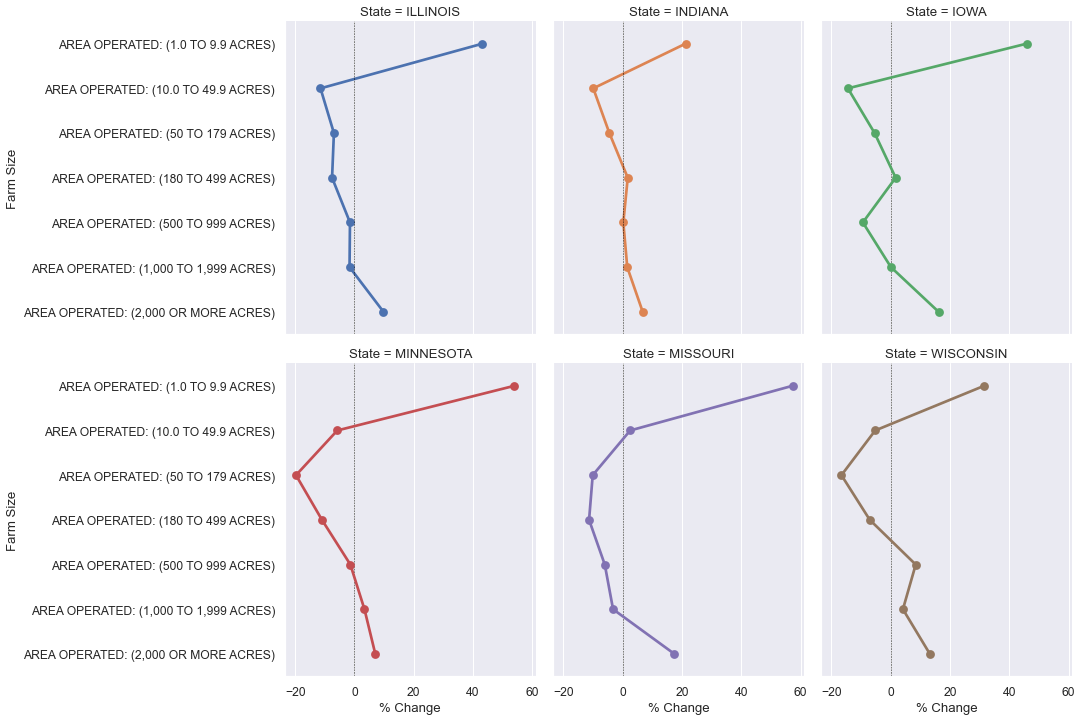

In [66]:
sns.set_theme(style="ticks")
sns.set(font_scale = 1.1)
g = sns.catplot(data = state_agg_area_oper_by_grp_size_2012_2017_pivot,
                x = "Perc_Change", y = "Farm Size",
                order = ['AREA OPERATED: (1.0 TO 9.9 ACRES)',
                         'AREA OPERATED: (10.0 TO 49.9 ACRES)',
                         'AREA OPERATED: (50 TO 179 ACRES)',
                         'AREA OPERATED: (180 TO 499 ACRES)',
                         'AREA OPERATED: (500 TO 999 ACRES)',
                         'AREA OPERATED: (1,000 TO 1,999 ACRES)',
                         'AREA OPERATED: (2,000 OR MORE ACRES)'],
                col = "State", col_wrap=3,hue = "State",
                xlim=(-20, 60), kind = "point")

(g.set_axis_labels("% Change", "Farm Size"))

line_position = [0]*6
for ax, pos in zip(g.axes.flat, line_position):
    ax.axvline(0, color = "black", linewidth = 0.5, linestyle = "--")

plt.show()

## Crops grown in the smallest farms - by State

Awaiting data from NASS Data Team

## Water Quality across monitoring stations across counties

### Analysis

In [229]:
water_station_df_raw = pd.read_csv("../Data/Water_monitoring_stations_Midwwest_States_byCounty.csv", dtype={'StateCode': object, 'CountyCode': object})

In [230]:
water_station_df_raw.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,ContributingDrainageAreaMeasure/MeasureUnitCode,LatitudeMeasure,LongitudeMeasure,SourceMapScaleNumeric,HorizontalAccuracyMeasure/MeasureValue,HorizontalAccuracyMeasure/MeasureUnitCode,HorizontalCollectionMethodName,HorizontalCoordinateReferenceSystemDatumName,VerticalMeasure/MeasureValue,VerticalMeasure/MeasureUnitCode,VerticalAccuracyMeasure/MeasureValue,VerticalAccuracyMeasure/MeasureUnitCode,VerticalCollectionMethodName,VerticalCoordinateReferenceSystemDatumName,CountryCode,StateCode,CountyCode,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-IA,USGS Iowa Water Science Center,USGS-05420500,"Mississippi River at Clinton, IA",Stream,NaN,7080101.0,85600.00,sq mi,NaN,NaN,41.780586,-90.252073,24000.0,5,seconds,Interpolated from MAP.,NAD83,562.68,feet,0.01,feet,Level or other surveyed method.,NGVD29,US,19,045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-IA,USGS Iowa Water Science Center,USGS-05451210,"South Fork Iowa River NE of New Providence, IA",Stream,NaN,7080207.0,224.00,sq mi,NaN,NaN,42.315306,-93.152194,24000.0,5,seconds,GNSS2 - Level 2 Quality Survey Grade Global Na...,NAD83,944.03,feet,0.13,feet,GNSS2 - Level 2 Quality Survey Grade Global Na...,NAVD88,US,19,083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-IA,USGS Iowa Water Science Center,USGS-05454050,"Muddy Cr abv Trtmnt Outfall at North Liberty, IA",Stream,NaN,7080209.0,3.94,sq mi,NaN,NaN,41.723889,-91.592778,NaN,1,seconds,Interpolated from Digital MAP.,NAD83,NaN,NaN,NaN,NaN,NaN,NaN,US,19,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-IA,USGS Iowa Water Science Center,USGS-05454051,"Muddy Cr at Trtmnt Effluent at North Liberty, IA",Stream,NaN,7080209.0,3.94,sq mi,NaN,NaN,41.723611,-91.592222,NaN,1,seconds,Interpolated from Digital MAP.,NAD83,NaN,NaN,NaN,NaN,NaN,NaN,US,19,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-IA,USGS Iowa Water Science Center,USGS-05454052,"Muddy Cr blw Trtmnt Outfall at North Liberty, IA",Stream,NaN,7080209.0,3.94,sq mi,NaN,NaN,41.723056,-91.591111,NaN,1,seconds,Interpolated from Digital MAP.,NAD83,NaN,NaN,NaN,NaN,NaN,NaN,US,19,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


Retaining only data from NWIS

In [239]:
water_station_df_nwis_raw = water_station_df_raw[water_station_df_raw["ProviderName"] == "NWIS"]

In [240]:
water_station_df_nwis_raw.shape

(267, 37)

In [238]:
len(water_station_df_raw.CountyCode.unique())

99

In [241]:
len(water_station_df_nwis_raw.CountyCode.unique())

51

No NWIS data available for 48 counties.<br>
For these counties, there is STORET data available, but there is no direct API to access water quality metrics from STORET data

Retaining only essential columns:

In [421]:
water_station_df_nwis = water_station_df_nwis_raw[["StateCode", "CountyCode","MonitoringLocationIdentifier", "LatitudeMeasure", "LongitudeMeasure"]]

Creating numeric `SiteID` from the `MonitoringLocationIdentifier` column by removing leading "USGS-"

In [422]:
water_station_df_nwis["SiteID"] = water_station_df_nwis['MonitoringLocationIdentifier'].str[5:]

In [423]:
water_station_df_nwis["SiteID"] = water_station_df_nwis["SiteID"].map(lambda x: x.lstrip('-'))

# This is to remove the "-" present in a few non-USGS Monitoring sites from NWIS, such as "IN002-375700087260016". These are present in IN and MN

In [305]:
water_station_df_nwis["MonitoringLocationIdentifier"][water_station_df_nwis['StateCode'] == '18']

42      USGS-405524087152701
43      USGS-410030087263101
47      USGS-411248087304901
66     IN002-375700087260016
67     IN002-381100086200016
68     IN002-381200085530010
69     IN002-384400085240015
70     IN002-385000086310010
71     IN002-390600084520012
72             USGS-03374100
73             USGS-04178500
74      USGS-375327087030301
75      USGS-375357087104401
76      USGS-380751085543601
77      USGS-381834085401801
78      USGS-383945086475901
79      USGS-384446085043201
80      USGS-385053084485901
81      USGS-394340085524601
82      USGS-410503085075101
83      USGS-410932085054201
84      USGS-413645087230701
85      USGS-413650087230601
86      USGS-413653087232201
87      USGS-413654087230501
88      USGS-413703087230501
89      USGS-413715087232101
90      USGS-413718087233701
91      USGS-413720087233901
92      USGS-413725087240601
93             USGS-03303280
94             USGS-03378500
254     USGS-392134084563200
255     USGS-395149084592900
256     USGS-3

In [306]:
water_station_df_nwis["SiteID"][water_station_df_nwis['StateCode'] == '18']

42     405524087152701
43     410030087263101
47     411248087304901
66     375700087260016
67     381100086200016
68     381200085530010
69     384400085240015
70     385000086310010
71     390600084520012
72            03374100
73            04178500
74     375327087030301
75     375357087104401
76     380751085543601
77     381834085401801
78     383945086475901
79     384446085043201
80     385053084485901
81     394340085524601
82     410503085075101
83     410932085054201
84     413645087230701
85     413650087230601
86     413653087232201
87     413654087230501
88     413703087230501
89     413715087232101
90     413718087233701
91     413720087233901
92     413725087240601
93            03303280
94            03378500
254    392134084563200
255    395149084592900
256    395248084491600
Name: SiteID, dtype: object

Procuring Water Quality Data from NWIS for the 267 sites from the 6 states considered

**State-wise**

In [296]:
sites_IL = list(water_station_df_nwis["SiteID"][water_station_df_nwis['StateCode'] == '17'])
sites_IN = list(water_station_df_nwis["SiteID"][water_station_df_nwis['StateCode'] == '18'])
sites_IA = list(water_station_df_nwis["SiteID"][water_station_df_nwis['StateCode'] == '19'])
sites_MN = list(water_station_df_nwis["SiteID"][water_station_df_nwis['StateCode'] == '27'])
sites_MO = list(water_station_df_nwis["SiteID"][water_station_df_nwis['StateCode'] == '29'])
sites_WI = list(water_station_df_nwis["SiteID"][water_station_df_nwis['StateCode'] == '55'])

State | # of NWIS Stations
--- | ---
IL | 36
IN | 35
IA | 27
MN | 49
MO | 107
WI | 13

In [278]:
water_quality_IL = nwis.get_record(sites=sites_IL, service='qwdata', start='2017-01-01', end='2021-12-31')
water_quality_IN = nwis.get_record(sites=sites_IN, service='qwdata', start='2017-01-01', end='2021-12-31')
water_quality_IA = nwis.get_record(sites=sites_IA, service='qwdata', start='2017-01-01', end='2021-12-31')
water_quality_MN = nwis.get_record(sites=sites_MN, service='qwdata', start='2017-01-01', end='2021-12-31')
water_quality_MO = nwis.get_record(sites=sites_MO, service='qwdata', start='2017-01-01', end='2021-12-31')
water_quality_WI = nwis.get_record(sites=sites_WI, service='qwdata', start='2017-01-01', end='2021-12-31')

In [311]:
water_quality_IL = water_quality_IL.reset_index()
water_quality_IN = water_quality_IL.reset_index()
water_quality_IA = water_quality_IL.reset_index()
water_quality_MN = water_quality_IL.reset_index()
water_quality_MO = water_quality_IL.reset_index()
water_quality_WI = water_quality_IL.reset_index()

**Overall (All 6 states)**

In [312]:
sites = list(water_station_df_nwis["SiteID"])

In [387]:
len(sites)

267

In [318]:
water_quality_raw = nwis.get_record(sites=sites, service='qwdata', start='2017-01-01', end='2021-12-31')

In [319]:
water_quality_raw = water_quality_raw.reset_index()

In [388]:
len(water_quality_raw.site_no.unique())

237

There are 30 NWIS sites for which we do not seem to have Water quality data

In [320]:
water_quality_raw.head()

,site_no,datetime,agency_cd,sample_end_dt,sample_end_tm,tm_datum_rlbty_cd,coll_ent_cd,medium_cd,project_cd,aqfr_cd,tu_id,body_part_id,hyd_cond_cd,samp_type_cd,hyd_event_cd,sample_lab_cm_txt,p00003,p00004,p00009,p00010,p00011,p00020,p00021,p00025,p00032,p00035,p00041,p00055,p00059,p00060,p00061,p00063,p00064,p00065,p00095,p00191,p00300,p00301,p00400,p00403,p00405,p00419,p00447,p00450,p00452,p00453,p00500,p00530,p00572,p00573,p00597,p00600,p00602,p00605,p00607,p00608,p00610,p00613,p00618,p00623,p00625,p00631,p00660,p00665,p00666,p00671,p00680,p00681,p00688,p00689,p00691,p00694,p00900,p00904,p00905,p00915,p00916,p00925,p00927,p00929,p00930,p00931,p00932,p00935,p00937,p00940,p00945,p00950,p00955,p01000,p01005,p01010,p01020,p01025,p01027,p01030,p01035,p01040,p01045,p01046,p01049,p01051,p01055,p01056,p01057,p01060,p01065,p01075,p01080,p01085,p01090,p01092,p01095,p01105,p01106,p01130,p01145,p01300,p01305,p01320,p01325,p01330,p01340,p01345,p01350,p01355,p01395,p04005,p04006,p04022,p04024,p04025,p04028,p04035,p04036,p04037,p04040,p04041,p04095,p04117,p04119,p04254,p07000,p09503,p17503,p19503,p22703,p29801,p30104,p30194,p30207,p30208,p30209,p30210,p30217,p30218,p30234,p31616,p31625,p31633,p31738,p31739,p31741,p31742,p31743,p31745,p31761,p31763,p31764,p31765,p31766,p31767,p31771,p31773,p31774,p31775,p31776,p31777,p31779,p31780,p31781,p31782,p31787,p31793,p31795,p31797,p31863,p31872,p31876,p31877,p31878,p31879,p31880,p31894,p31895,p31896,p32000,p32101,p32102,p32103,p32104,p32105,p32106,p32285,p32295,p32315,p32316,p32318,p32319,p32320,p32321,p34010,p34030,p34200,p34205,p34215,p34220,p34230,p34242,p34247,p34253,p34273,p34278,p34283,p34292,p34301,p34311,p34320,p34336,p34341,p34362,p34371,p34376,p34381,p34386,p34396,p34403,p34408,p34413,p34418,p34423,p34428,p34433,p34438,p34447,p34452,p34461,p34469,p34475,p34485,p34488,p34496,p34501,p34506,p34511,p34516,p34521,p34526,p34536,p34541,p34546,p34551,p34556,p34566,p34571,p34581,p34586,p34591,p34596,p34601,p34606,p34611,p34616,p34621,p34626,p34636,p34641,p34646,p34653,p34657,p34668,p34694,p34696,p34699,p34704,p38454,p38775,p38932,p38933,p39032,p39046,p39050,p39056,p39086,p39087,p39100,p39110,p39175,p39180,p39301,p39311,p39321,p39341,p39381,p39415,p39531,p39532,p39542,p39570,p39571,p39572,p39601,p39630,p39631,p39632,p39700,p39702,p39750,p45013,p45028,p45617,p46342,p49260,p49295,p49446,p49460,p49538,p49570,p49933,p49934,p49954,p49991,p49999,p50000,p50002,p50004,p50005,p50014,p50015,p50016,p50276,p50280,p50281,p50282,p50283,p50468,p50569,p50624,p50833,p50985,p51290,p51754,p51755,p51756,p51758,p51760,p52001,p52686,p52687,p52688,p52689,p52690,p52691,p52692,p52693,p52694,p52695,p52696,p52814,p52815,p52816,p52817,p52836,p52885,p53515,p53517,p53518,p53519,p53520,p53521,p53522,p53523,p53524,p53525,p53526,p53527,p53528,p53529,p53530,p53531,p53532,p53533,p53534,p53954,p53961,p53962,p53981,p53982,p54091,p54092,p54093,p54094,p54095,p54096,p54097,p54104,p54105,p54106,p54107,p54109,p54110,p54111,p54112,p54113,p54114,p54115,p54116,p54117,p54118,p54119,p54120,p54121,p54122,p54123,p61040,p61046,p61047,p61585,p61586,p61590,p61591,p61593,p61594,p61595,p61596,p61598,p61599,p61600,p61601,p61606,p61610,p61618,p61620,p61625,p61627,p61633,p61635,p61636,p61640,p61644,p61645,p61646,p61652,p61664,p61666,p61668,p61674,p61678,p61679,p61680,p61682,p61683,p61685,p61687,p61703,p61704,p61707,p61708,p61726,p61944,p61945,p61947,p61948,p62046,p62047,p62166,p62167,p62168,p62169,p62170,p62174,p62359,p62360,p62461,p62485,p62486,p62636,p62639,p62642,p62645,p62649,p62721,p62722,p62805,p62806,p62807,p62808,p62809,p62810,p62811,p62812,p62813,p62814,p62815,p62816,p62817,p62818,p62819,p62823,p62824,p62825,p62826,p62827,p62828,p62829,p62830,p62831,p62832,p62833,p62834,p62835,p62841,p62842,p62854,p62855,p62902,p62904,p62905,p62971,p63145,p63147,p63149,p63162,p63163,p63165,p63166,p63167,p63168,p63170,p63171,p63173,p63175,p63176,p63178,p63179,p63180,p63181,p63182,p63183,p63184,p63185,p63186,p63187,p63189,p63192,p63194,p63195,p63196,p63198,p63202,p6

We are interested in specific agricultural pollutants in the water, as below:
    
Obtained from https://help.waterdata.usgs.gov/parameter_cd_nm

|Parameter Code|Group|Paramter|Units|
|---|---|---|---|
|00625|Nutrient|Ammonia plus organic nitrogen, water, unfiltered, milligrams per liter as nitrogen|mg/l as N|
|00631|Nutrient|Nitrate plus nitrite, water, filtered, milligrams per liter as nitrogen|mg/l as N|
|00665|Nutrient|Phosphorus, water, unfiltered, milligrams per liter as phosphorus|mg/l as P|

Retaining only essential columns from each of the above state-wise dataframes

In [370]:
water_quality = water_quality_raw[["site_no", "p00625", "p00631", "p00665"]]

In [371]:
water_quality.head()

,site_no,p00625,p00631,p00665
0,03303280,0.74,1.44,0.239 d
1,03303280,0.74,1.52,0.278 d
2,03303280,0.61,1.22,0.182
3,03303280,0.39,1.28,0.097
4,03303280,1.0,1.02,0.399 d


In [372]:
type(water_quality['p00625'][0])

str

Retaining only the metric (numeric) part of each measure and converting them to float for use in calculations

In [373]:
water_quality["p00625"] = water_quality["p00625"].str.extract('(\d+\.*\d*)', expand=False).astype(float)
water_quality["p00631"] = water_quality["p00631"].str.extract('(\d+\.*\d*)', expand=False).astype(float)
water_quality["p00665"] = water_quality["p00665"].str.extract('(\d+\.*\d*)', expand=False).astype(float)

Renamaing Parameter Code columns to Pollutant names

In [375]:
water_quality = water_quality.rename(columns={"p00625": "Ammonia plus organic nitrogen", "p00631": "Nitrate plus nitrite", "p00665": "Phosphorus"})

Note that there are also sites which are included in the dataset for other parameters measured, and do not measure any of the 3 parameters we are interested in, as shown below

In [390]:
water_quality[water_quality['site_no']=='04085279'].head()

,site_no,Ammonia plus organic nitrogen,Nitrate plus nitrite,Phosphorus
482,04085279,NaN,NaN,NaN
483,04085279,NaN,NaN,NaN


Averaging the metric measurements (ignoring all NaNs) per Monitoring Site

In [391]:
site_agg_water_quality = water_quality.groupby(['site_no']).agg({'Ammonia plus organic nitrogen': 'mean', 'Nitrate plus nitrite':'mean', 'Phosphorus':'mean'}).reset_index()

In [392]:
site_agg_water_quality

,site_no,Ammonia plus organic nitrogen,Nitrate plus nitrite,Phosphorus
0,03303280,0.512923,1.000656,0.160096
1,03374100,0.771494,1.297161,0.175805
2,03378500,0.915397,2.110948,0.238935
3,03612600,0.529437,1.138922,0.174617
4,04085279,NaN,NaN,NaN
...,...,...,...,...
232,450810093065001,NaN,NaN,NaN
233,450907093100501,NaN,NaN,NaN
234,450908093100401,NaN,NaN,NaN
235,450910093100601,NaN,NaN,NaN


Removing rows with all three columns as NaN

In [418]:
site_agg_water_quality_filtered = site_agg_water_quality.dropna(thresh=2)

In [419]:
site_agg_water_quality_filtered

,site_no,Ammonia plus organic nitrogen,Nitrate plus nitrite,Phosphorus
0,03303280,0.512923,1.000656,0.160096
1,03374100,0.771494,1.297161,0.175805
2,03378500,0.915397,2.110948,0.238935
3,03612600,0.529437,1.138922,0.174617
10,05288705,0.847119,0.264212,0.079508
...,...,...,...,...
208,430728088132801,NaN,3.080000,NaN
209,431037090043401,NaN,6.003636,NaN
211,431053090042702,NaN,11.145455,NaN
212,443320089212303,NaN,2.351818,NaN


In [427]:
water_station_geo_map = water_station_df_nwis[['SiteID', 'LatitudeMeasure', 'LongitudeMeasure']]

In [428]:
water_station_geo_map.head()

,SiteID,LatitudeMeasure,LongitudeMeasure
0,05420500,41.780586,-90.252073
1,05451210,42.315306,-93.152194
2,05454050,41.723889,-91.592778
3,05454051,41.723611,-91.592222
4,05454052,41.723056,-91.591111


Adding Lat, Long info to the site_no from station data

In [429]:
site_agg_water_quality_filtered_geo = pd.merge(site_agg_water_quality_filtered, water_station_geo_map, left_on='site_no', right_on='SiteID')

### Result/Visualization

In [430]:
site_agg_water_quality_filtered_geo

,site_no,Ammonia plus organic nitrogen,Nitrate plus nitrite,Phosphorus,SiteID,LatitudeMeasure,LongitudeMeasure
0,03303280,0.512923,1.000656,0.160096,03303280,37.899501,-86.705542
1,03374100,0.771494,1.297161,0.175805,03374100,38.489770,-87.550023
2,03378500,0.915397,2.110948,0.238935,03378500,38.130879,-87.941419
3,03612600,0.529437,1.138922,0.174617,03612600,37.179219,-89.058404
4,05288705,0.847119,0.264212,0.079508,05288705,45.049965,-93.310227
...,...,...,...,...,...,...,...
121,430728088132801,NaN,3.080000,NaN,430728088132801,43.124722,-88.224667
122,431037090043401,NaN,6.003636,NaN,431037090043401,43.177056,-90.076194
123,431053090042702,NaN,11.145455,NaN,431053090042702,43.181294,-90.074214
124,443320089212303,NaN,2.351818,NaN,443320089212303,44.555675,-89.356331


Preparing individual tables for each measure, for ease of mapping

In [431]:
site_agg_water_quality_NH3pN_geo = site_agg_water_quality_filtered_geo[['site_no', 'LatitudeMeasure','LongitudeMeasure','Ammonia plus organic nitrogen']]
site_agg_water_quality_NO3pNO2_geo = site_agg_water_quality_filtered_geo[['site_no', 'LatitudeMeasure','LongitudeMeasure','Nitrate plus nitrite']]
site_agg_water_quality_Phos_geo = site_agg_water_quality_filtered_geo[['site_no', 'LatitudeMeasure','LongitudeMeasure','Phosphorus']]

## Acres of Pollinated Crops with no nearby pollinator habitat

### Analysis

Importing data mapping HUC 12 codes to states

In [432]:
epa_reg5_huc_state_map_raw = pd.read_csv("../Data/Pollinator Habitat/20211112-wsio-indicator-data-v2.3-epa-region05.csv", dtype={'Hydrologic Unit Code 12-Digit (HUC12)': object})
epa_reg6_huc_state_map_raw = pd.read_csv("../Data/Pollinator Habitat/20211112-wsio-indicator-data-v2.3-epa-region06.csv", dtype={'Hydrologic Unit Code 12-Digit (HUC12)': object})
epa_reg7_huc_state_map_raw = pd.read_csv("../Data/Pollinator Habitat/20211112-wsio-indicator-data-v2.3-epa-region07.csv", dtype={'Hydrologic Unit Code 12-Digit (HUC12)': object})

Retaining only relevant columns

In [433]:
epa_reg5_huc_state_map = epa_reg5_huc_state_map_raw[["Hydrologic Unit Code 12-Digit (HUC12)","Majority State in HUC12 (2013)"]]
epa_reg6_huc_state_map = epa_reg6_huc_state_map_raw[["Hydrologic Unit Code 12-Digit (HUC12)","Majority State in HUC12 (2013)"]]
epa_reg7_huc_state_map = epa_reg7_huc_state_map_raw[["Hydrologic Unit Code 12-Digit (HUC12)","Majority State in HUC12 (2013)"]]

In [435]:
epa_reg5_huc_state_map["Majority State in HUC12 (2013)"].unique()

array(['MN', 'WI', 'MI', 'IN', 'IL', 'OH', 'PA', 'WV', 'KY', 'SD', 'IA',
       'MO', 'ND'], dtype=object)

In [ ]:
MN
WI
IN
IL
IA
MO

In [436]:
epa_reg6_huc_state_map["Majority State in HUC12 (2013)"].unique()

array(['MS', 'LA', 'TN', 'AR', 'MO', 'CO', 'NM', 'OK', 'KS', 'TX', 'AZ'],
      dtype=object)

In [ ]:
MO

In [437]:
epa_reg7_huc_state_map["Majority State in HUC12 (2013)"].unique()

array(['IA', 'MN', 'WI', 'IL', 'MO', 'KY', 'TN', 'AR', 'SD', 'NE', 'WY',
       'CO', 'KS', 'OK'], dtype=object)

In [ ]:
IA
MN
WI
IL
MO

Retaining only states of interest

In [439]:
epa_reg5_huc_state_map_filter = epa_reg5_huc_state_map[epa_reg5_huc_state_map["Majority State in HUC12 (2013)"].isin(['MN','WI','IN','IL','IA','MO'])]

In [443]:
epa_reg6_huc_state_map_filter = epa_reg6_huc_state_map[epa_reg6_huc_state_map["Majority State in HUC12 (2013)"] == 'MO']

In [447]:
epa_reg7_huc_state_map_filter = epa_reg7_huc_state_map[epa_reg7_huc_state_map["Majority State in HUC12 (2013)"].isin(['MN','WI','IL','IA','MO'])]

In [450]:
epa_allreg_huc_state_map_filter = pd.concat([epa_reg5_huc_state_map_filter, epa_reg6_huc_state_map_filter, epa_reg7_huc_state_map_filter])

In [453]:
epa_reg5_huc_state_map_filter.shape[0] + epa_reg6_huc_state_map_filter.shape[0] + epa_reg7_huc_state_map_filter.shape[0]

11056

In [456]:
len(epa_allreg_huc_state_map_filter["Hydrologic Unit Code 12-Digit (HUC12)"].unique())

10881

In [459]:
epa_allreg_huc_state_map_filter[epa_allreg_huc_state_map_filter.duplicated(subset=["Hydrologic Unit Code 12-Digit (HUC12)"], keep=False)].sort_values(by=["Hydrologic Unit Code 12-Digit (HUC12)"])

,Hydrologic Unit Code 12-Digit (HUC12),Majority State in HUC12 (2013)
6665,070200090104,IA
3,070200090104,IA
4,070200090201,IA
6666,070200090201,IA
6667,070200090202,MN
...,...,...
2693,110702080502,MO
7624,110702080504,MO
2695,110702080504,MO
2696,110702080505,MO


In [476]:
dup_rows_huc_state_map = epa_allreg_huc_state_map_filter[epa_allreg_huc_state_map_filter.duplicated(subset=["Hydrologic Unit Code 12-Digit (HUC12)"], keep=False)]

In [479]:
num_maj_state_per_huc = dup_rows_huc_state_map.groupby(["Hydrologic Unit Code 12-Digit (HUC12)"]).agg(Maj_State_Cnt = ("Majority State in HUC12 (2013)", pd.Series.nunique)).reset_index()

In [480]:
len(num_maj_state_per_huc["Hydrologic Unit Code 12-Digit (HUC12)"][num_maj_state_per_huc["Maj_State_Cnt"] > 1])

0

So there are no two Watersheds with different Major States mapped to them. We can thus remove the 175 duplicate rows from the main mapping table

In [482]:
epa_allreg_huc_state_map_filter.drop_duplicates(inplace = True)

Importing data on Acres of Pollinated Crops with no nearby pollinator habitat

In [486]:
acres_with_no_polli = pd.read_csv("../Data/Pollinator Habitat/Pollination_NHDPv2_WBD.csv", dtype={'HUC_12': object})

In [487]:
acres_with_no_polli.head()

,HUC_12,Acres_Unpo
0,010100020101,0.0
1,010100020102,0.0
2,010100020103,0.0
3,010100020104,0.0
4,010100020105,0.0


Adding State info to the above

In [488]:
state_acres_with_no_polli = pd.merge(acres_with_no_polli, epa_allreg_huc_state_map_filter, left_on='HUC_12', right_on='Hydrologic Unit Code 12-Digit (HUC12)')

In [492]:
len(acres_with_no_polli['HUC_12'].unique())

82915

In [491]:
len(epa_allreg_huc_state_map_filter['Hydrologic Unit Code 12-Digit (HUC12)'].unique())

10881

In [493]:
len(state_acres_with_no_polli['HUC_12'].unique())

10881

In [494]:
state_acres_with_no_polli.head()

,HUC_12,Acres_Unpo,Hydrologic Unit Code 12-Digit (HUC12),Majority State in HUC12 (2013)
0,040101010101,0.0,040101010101,MN
1,040101010201,0.0,040101010201,MN
2,040101010202,0.0,040101010202,MN
3,040101010203,0.0,040101010203,MN
4,040101010204,0.0,040101010204,MN


In [502]:
state_acres_with_no_polli.groupby(["Majority State in HUC12 (2013)"]).agg(Total_WaterSheds = ("Majority State in HUC12 (2013)", len)).reset_index()

,Majority State in HUC12 (2013),Total_WaterSheds
0,IA,1614
1,IL,1774
2,IN,1484
3,MN,2389
4,MO,1876
5,WI,1744


Aggreagating the total acres per state with no nearby pollinator habitat

In [496]:
state_agg_acres_with_no_polli = state_acres_with_no_polli.groupby(["Majority State in HUC12 (2013)"]).agg(Total_Acres_Unpo = ("Acres_Unpo", sum)).reset_index()

### Result/Visualization

In [501]:
state_agg_acres_with_no_polli.head(6)

,Majority State in HUC12 (2013),Total_Acres_Unpo
0,IA,8798.385714
1,IL,243123.624850
2,IN,3470.249499
3,MN,2049.812859
4,MO,7779.817220
5,WI,0.000000


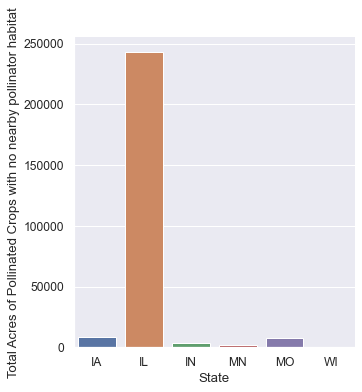

In [517]:
sns.set_theme(style="ticks")
sns.set(font_scale = 1.1)
g = sns.catplot(data = state_agg_acres_with_no_polli,
                x = "Majority State in HUC12 (2013)", y = "Total_Acres_Unpo",
                kind = "bar")

(g.set_axis_labels("State", "Total Acres of Pollinated Crops with no nearby pollinator habitat"))

plt.show()

## Observing richness in Bird Species across Watersheds

### Analysis

Importing biodiversity data

In [503]:
biodiversity_raw = pd.read_csv("../Data/Pollinator Habitat/Biodiversity.csv", dtype={'HUC_12': object})

Retaining columns of interest

In [507]:
biodiversity = biodiversity_raw[['HUC_12','Bird_All_Mean','PIF_CSD_Mean']]

In [508]:
biodiversity.head()

,HUC_12,Bird_All_Mean,PIF_CSD_Mean
0,080802060603,90.620,2.783
1,120402010400,91.220,2.929
2,080801030504,82.860,2.495
3,080802060602,94.057,3.592
4,080903010502,78.685,1.405


Adding State info to the above

In [509]:
state_biodiversity = pd.merge(biodiversity, epa_allreg_huc_state_map_filter, left_on='HUC_12', right_on='Hydrologic Unit Code 12-Digit (HUC12)')

In [510]:
len(biodiversity['HUC_12'].unique())

82915

In [511]:
len(epa_allreg_huc_state_map_filter['Hydrologic Unit Code 12-Digit (HUC12)'].unique())

10881

In [512]:
len(state_biodiversity['HUC_12'].unique())

10881

In [513]:
state_biodiversity.head()

,HUC_12,Bird_All_Mean,PIF_CSD_Mean,Hydrologic Unit Code 12-Digit (HUC12),Majority State in HUC12 (2013)
0,090201060302,62.987,7.627,090201060302,MN
1,090203120303,60.682,6.637,090203120303,MN
2,090201060705,62.781,7.460,090201060705,MN
3,090203120604,59.137,6.492,090203120604,MN
4,090300010402,61.270,4.164,090300010402,MN


Aggreagating the average number of bird species in a state, and the average number of common species in steep decline

In [515]:
state_agg_biodiversity = state_biodiversity.groupby(["Majority State in HUC12 (2013)"]).agg({'Bird_All_Mean':'mean', 'PIF_CSD_Mean':'mean'}).reset_index()

### Result/Visualization

In [516]:
state_agg_biodiversity.head(6)

,Majority State in HUC12 (2013),Bird_All_Mean,PIF_CSD_Mean
0,IA,58.411778,8.812506
1,IL,57.718097,8.641050
2,IN,57.707513,8.381661
3,MN,57.382829,6.213779
4,MO,61.385675,8.097937
5,WI,60.798364,6.594466


## Rapid Carbon Assessment (RaCA) Cumulative Soil Organic Carbon Stock

### Analysis

Collecting Site and Stock data for each state for the analysis

In [68]:
# Site data
# Parameter: what = site
site_data_IL_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=site&state=il&plaintext=1')
site_data_IN_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=site&state=in&plaintext=1')
site_data_IA_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=site&state=ia&plaintext=1')
site_data_MN_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=site&state=mn&plaintext=1')
site_data_MO_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=site&state=mo&plaintext=1')
site_data_WI_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=site&state=wi&plaintext=1')

Extracting data from the response object

In [69]:
site_data_IL_str = StringIO(site_data_IL_res.text)
site_data_IN_str = StringIO(site_data_IN_res.text)
site_data_IA_str = StringIO(site_data_IA_res.text)
site_data_MN_str = StringIO(site_data_MN_res.text)
site_data_MO_str = StringIO(site_data_MO_res.text)
site_data_WI_str = StringIO(site_data_WI_res.text)

In [70]:
site_data_IL_dfraw = pd.read_csv(site_data_IL_str, sep="|")
site_data_IN_dfraw = pd.read_csv(site_data_IN_str, sep="|")
site_data_IA_dfraw = pd.read_csv(site_data_IA_str, sep="|")
site_data_MN_dfraw = pd.read_csv(site_data_MN_str, sep="|")
site_data_MO_dfraw = pd.read_csv(site_data_MO_str, sep="|")
site_data_WI_dfraw = pd.read_csv(site_data_WI_str, sep="|")

Appending data of all 6 states into one dataframe

In [71]:
site_data_raw = pd.concat([site_data_IL_dfraw, 
                       site_data_IN_dfraw, 
                       site_data_IA_dfraw, 
                       site_data_MN_dfraw, 
                       site_data_MO_dfraw, 
                       site_data_WI_dfraw])

Retaining only relevant columns

In [72]:
site_data = site_data_raw[["rcasiteid","rcapid","plotconfig","obs_date","drainagecl","taxonname","x","y","state"]]

In [73]:
site_data.shape

(3628, 9)

In [74]:
site_data.head(20)

,rcasiteid,rcapid,plotconfig,obs_date,drainagecl,taxonname,x,y,state
0,C1001F01,C1001F011,Standard cluster,2011-03-31 07:00:00+00,Somewhat excessively drained,Elizabeth,-90.27,42.40,IL
1,C1001F01,C1001F012,Standard cluster,2011-03-31 07:00:00+00,Somewhat excessively drained,Elizabeth,-90.27,42.40,IL
2,C1001F01,C1001F013,Standard cluster,2011-03-31 07:00:00+00,Somewhat excessively drained,Elizabeth,-90.27,42.40,IL
3,C1001F01,C1001F014,Standard cluster,2011-03-31 07:00:00+00,Somewhat excessively drained,Elizabeth,-90.27,42.40,IL
4,C1001F01,C1001F015,Standard cluster,2011-03-31 07:00:00+00,Somewhat excessively drained,Edmund,-90.27,42.40,IL
5,C1006C24,C1006C241,Chain,2011-03-31 07:00:00+00,Well drained,Fayette,-90.14,42.29,IL
6,C1006C24,C1006C242,Chain,2011-03-31 07:00:00+00,Well drained,Dubuque,-90.14,42.29,IL
7,C1006C24,C1006C243,Chain,2011-03-31 07:00:00+00,Well drained,Dubuque,-90.14,42.29,IL
8,C1006C24,C1006C244,Chain,2011-03-31 07:00:00+00,Well drained,Fayette,-90.14,42.29,IL
9,C1006C24,C1006C245,Chain,2011-03-31 07:00:00+00,Well drained,Fayette,-90.14,42.29,IL


In [75]:
site_data.groupby(['state']).agg({"rcasiteid":pd.Series.nunique, "rcapid":pd.Series.nunique})

,rcasiteid,rcapid
state,,
IA,88,436
IL,132,652
IN,86,426
MN,162,799
MO,148,732
WI,118,583


In [76]:
# Total number of sites
pd.Series.nunique(site_data['rcasiteid'])

734

In [77]:
# Total number of pedons
pd.Series.nunique(site_data['rcapid'])

3628

In [78]:
# Soil Organic Carbon Stock data
# Parameter: what = stock
socstock_data_IL_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=stock&state=il&plaintext=1')
socstock_data_IN_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=stock&state=in&plaintext=1')
socstock_data_IA_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=stock&state=ia&plaintext=1')
socstock_data_MN_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=stock&state=mn&plaintext=1')
socstock_data_MO_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=stock&state=mo&plaintext=1')
socstock_data_WI_res = requests.get('http://casoilresource.lawr.ucdavis.edu/soil_web/rca/rca_query.php?what=stock&state=wi&plaintext=1')

Extracting data from the response object

In [79]:
socstock_data_IL_str = StringIO(socstock_data_IL_res.text)
socstock_data_IN_str = StringIO(socstock_data_IN_res.text)
socstock_data_IA_str = StringIO(socstock_data_IA_res.text)
socstock_data_MN_str = StringIO(socstock_data_MN_res.text)
socstock_data_MO_str = StringIO(socstock_data_MO_res.text)
socstock_data_WI_str = StringIO(socstock_data_WI_res.text)

In [80]:
socstock_data_IL_dfraw = pd.read_csv(socstock_data_IL_str, sep="|")
socstock_data_IN_dfraw = pd.read_csv(socstock_data_IN_str, sep="|")
socstock_data_IA_dfraw = pd.read_csv(socstock_data_IA_str, sep="|")
socstock_data_MN_dfraw = pd.read_csv(socstock_data_MN_str, sep="|")
socstock_data_MO_dfraw = pd.read_csv(socstock_data_MO_str, sep="|")
socstock_data_WI_dfraw = pd.read_csv(socstock_data_WI_str, sep="|")

Appending data of all 6 states into one dataframe

In [81]:
socstock_data_raw = pd.concat([socstock_data_IL_dfraw, 
                       socstock_data_IN_dfraw, 
                       socstock_data_IA_dfraw, 
                       socstock_data_MN_dfraw, 
                       socstock_data_MO_dfraw, 
                       socstock_data_WI_dfraw])

In [82]:
socstock_data_raw.head()

,rcapid,value_5cm,sd_5cm,value_10cm,sd_10cm,value_20cm,sd_20cm,value_30cm,sd_30cm,value_50cm,sd_50cm,value_100cm,sd_100cm
0,C1001F011,15.035969,2.859948,27.621351,3.705903,53.394195,9.236261,60.496768,10.622479,61.333404,10.317682,59.660371,10.905945
1,C1001F012,32.023036,19.007621,53.447945,24.915874,91.444941,41.508499,109.743651,53.522872,111.480396,51.741731,105.765696,52.441709
2,C1001F013,5.100368,3.231813,8.729691,4.122404,15.516575,8.103041,16.679342,8.198647,16.192271,7.202643,15.742607,7.836009
3,C1001F014,6.111000,3.631338,9.834903,4.689238,16.798523,8.069883,15.907836,7.600510,16.384135,7.988447,15.578285,8.032122
4,C1001F015,13.962522,7.935598,23.655780,11.174580,43.783635,19.948277,51.268033,23.955952,52.510980,24.208108,55.350387,22.276376


Retaining only relevant columns

In [83]:
socstock_data = socstock_data_raw[["rcapid","value_5cm","value_30cm","value_100cm"]]

In [84]:
socstock_data.shape

(3623, 4)

The stock data is missing data for 1 site (5 pedons) - which is fine

Creating new dataset with site specific stock data and coordinates

In [85]:
site_socstock_data = pd.merge(socstock_data, site_data, left_on='rcapid', right_on='rcapid')

In [86]:
site_socstock_data.shape

(3623, 12)

In [87]:
site_socstock_data.head()

,rcapid,value_5cm,value_30cm,value_100cm,rcasiteid,plotconfig,obs_date,drainagecl,taxonname,x,y,state
0,C1001F011,15.035969,60.496768,59.660371,C1001F01,Standard cluster,2011-03-31 07:00:00+00,Somewhat excessively drained,Elizabeth,-90.27,42.4,IL
1,C1001F012,32.023036,109.743651,105.765696,C1001F01,Standard cluster,2011-03-31 07:00:00+00,Somewhat excessively drained,Elizabeth,-90.27,42.4,IL
2,C1001F013,5.100368,16.679342,15.742607,C1001F01,Standard cluster,2011-03-31 07:00:00+00,Somewhat excessively drained,Elizabeth,-90.27,42.4,IL
3,C1001F014,6.111000,15.907836,15.578285,C1001F01,Standard cluster,2011-03-31 07:00:00+00,Somewhat excessively drained,Elizabeth,-90.27,42.4,IL
4,C1001F015,13.962522,51.268033,55.350387,C1001F01,Standard cluster,2011-03-31 07:00:00+00,Somewhat excessively drained,Edmund,-90.27,42.4,IL


For our analysis we will use the SOC data at 100cm depth - and we will find the mean at a site level, instead of a pedon level. Note: All pedons for every site have same site-level (lat, long). Additionally this site-level (lat, long) is at the precision of 2 decimal points due to confidentiality

This is the approach followed here: [NCSS Tech SOC Stock](http://ncss-tech.github.io/AQP/soilDB/RaCA-demo.html#:~:text=Soil%20Organic%20Carbon%20Stock%20Data)

In [88]:
site_socstock_100cm_data = site_socstock_data[["rcasiteid","x","y","state","value_100cm"]]

Calculating mean site-level SoC at 100cm depth

In [89]:
site_agg_socstock_100cm_data = site_socstock_100cm_data.groupby(['rcasiteid','x','y','state']).agg(SOCstock100 = ("value_100cm", np.mean)).reset_index()

In [90]:
site_agg_socstock_100cm_data.shape

(733, 5)

In [91]:
site_agg_socstock_100cm_data.head(20)

,rcasiteid,x,y,state,SOCstock100
0,A1011X98,-96.07,44.18,MN,296.352958
1,A1107P95,-86.24,41.08,IN,480.592266
2,A1611F63,-92.89,37.82,MO,172.568140
3,A1611F85,-92.68,36.73,MO,417.973984
4,C0501P04,-94.10,37.47,MO,384.704174
5,C0501P07,-94.46,37.57,MO,203.347029
6,C0503P02,-94.16,38.27,MO,374.336025
7,C0503P04,-94.46,38.15,MO,315.615683
8,C0503W07,-94.15,38.75,MO,193.277387
9,C0505F03,-93.99,37.95,MO,194.924447


Importing Land-use details from the CSV obtained from RaCA zip file download

In [92]:
site_LU_sample_raw = pd.read_csv("../Data/RaCA_samples.csv", thousands=',')

In [93]:
site_LU_sample = site_LU_sample_raw[['rcasiteid','LU']]

In [94]:
len(site_LU_sample['rcasiteid'].unique())

6418

Verifying one-to-one mapping for `rcasiteid` and Land-Use:

In [95]:
site_LU_sample.groupby(['rcasiteid']).agg({"LU":pd.Series.nunique}).sort_values(by=["LU"], ascending = False)

,LU
rcasiteid,
F0606F04,2
A0108P92,1
C1306F01,1
C1307C02,1
C1307C01,1
...,...
C0707C05,1
C0707C04,1
C0707C03,1


In [96]:
site_LU_sample_raw[site_LU_sample_raw['rcasiteid'] == 'F0606F04']

,samp,sample.id,TOP,BOT,hzn_desgn,rcasiteid,pedon_no,MO,MOGr,hor_top,...,c_tot_ncs,n_tot_ncs,s_tot_ncs,caco3,efferv_1nhcl,M,Model_desg,Texture,Measure_BD,Model_BD
45639,F0606F041-1,45121.0,0.0,8.0,a,F0606F04,1,6,606,0.0,...,2.070470,0.159423,0.026401,0.465108,slight,A,A,fsl,0.564495,0.661022
45640,F0606F041-2,45122.0,8.0,19.0,bw,F0606F04,1,6,606,8.0,...,1.542147,0.113213,0.016319,0.378107,slight,B,B,fsl,0.892906,0.931004
45641,F0606F041-3,45123.0,19.0,19.0,r,F0606F04,1,6,606,19.0,...,NaN,NaN,NaN,NaN,NaN,R,R,None,NaN,1.340902
45642,F0606F042-1,45124.0,0.0,11.0,ac,F0606F04,2,6,606,0.0,...,NaN,NaN,NaN,NaN,NaN,A,AC,fsl,1.026458,1.029029
45643,F0606F042-2,45125.0,11.0,11.0,r,F0606F04,2,6,606,11.0,...,NaN,NaN,NaN,NaN,NaN,R,R,None,NaN,1.340902
45644,F0606F043-3,45126.0,3.0,11.0,a,F0606F04,3,6,606,0.0,...,NaN,NaN,NaN,NaN,none,A,A,l,1.009462,1.045177
45645,F0606F043-4,45127.0,11.0,26.0,bk,F0606F04,3,6,606,11.0,...,NaN,NaN,NaN,NaN,NaN,B,Bk,fsl,1.005139,1.084088
45646,F0606F043-5,45128.0,26.0,26.0,r,F0606F04,3,6,606,26.0,...,NaN,NaN,NaN,NaN,NaN,R,R,None,NaN,1.337403
45647,F0606F044-1,45129.0,0.0,14.0,ac,F0606F04,4,6,606,0.0,...,NaN,NaN,NaN,NaN,NaN,A,AC,fsl,1.254701,1.251059
45648,F0606F044-2,45130.0,14.0,14.0,r,F0606F04,4,6,606,14.0,...,NaN,NaN,NaN,NaN,NaN,R,R,None,NaN,1.341235


In [97]:
site_agg_socstock_100cm_data[site_agg_socstock_100cm_data['rcasiteid'] == 'F0606F04']

,rcasiteid,x,y,state,SOCstock100


This site is not within the purview of our states of interest, so we shall ignore it

In [98]:
# Removing duplicate rows and retaining site-level details
site_LU_sample.drop_duplicates(inplace = True)

In [99]:
site_LU_sample.shape

(6419, 2)

Adding LU info to sites of interest

In [100]:
site_agg_socstock_100cm_LU_data = pd.merge(site_agg_socstock_100cm_data, site_LU_sample, left_on='rcasiteid', right_on='rcasiteid')

In [101]:
site_agg_socstock_100cm_LU_data.head(10)

,rcasiteid,x,y,state,SOCstock100,LU
0,A1011X98,-96.07,44.18,MN,296.352958,X
1,A1107P95,-86.24,41.08,IN,480.592266,P
2,A1611F63,-92.89,37.82,MO,172.568140,F
3,A1611F85,-92.68,36.73,MO,417.973984,F
4,C0501P04,-94.10,37.47,MO,384.704174,P
5,C0501P07,-94.46,37.57,MO,203.347029,P
6,C0503P02,-94.16,38.27,MO,374.336025,P
7,C0503P04,-94.46,38.15,MO,315.615683,P
8,C0503W07,-94.15,38.75,MO,193.277387,W
9,C0505F03,-93.99,37.95,MO,194.924447,F


In [102]:
site_agg_socstock_100cm_LU_data.shape

(733, 6)

In [103]:
site_agg_socstock_100cm_LU_data['LU'].unique()

array(['X', 'P', 'F', 'W', 'C', 'R'], dtype=object)

Adding details of Land-Use cover to the above sites

In [104]:
site_agg_socstock_100cm_LU_data['LandUse'] = np.select(
    [
        site_agg_socstock_100cm_LU_data['LU'] == 'X', 
        site_agg_socstock_100cm_LU_data['LU'] == 'P', 
        site_agg_socstock_100cm_LU_data['LU'] == 'F', 
        site_agg_socstock_100cm_LU_data['LU'] == 'W', 
        site_agg_socstock_100cm_LU_data['LU'] == 'C', 
        site_agg_socstock_100cm_LU_data['LU'] == 'R'
    ], 
    [
        'CRP', 
        'Pastureland',
        'Forestland',
        'Wetland',
        'Cropland',
        'Rangeland'
    ]
)

In [105]:
len(site_agg_socstock_100cm_LU_data[site_agg_socstock_100cm_LU_data['LU'].isin(['C','P'])])

441

441 (out of 733, so approx 60%) sites for which we have SoC information are CropLands or Pasturelands

In [106]:
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(site_agg_socstock_100cm_LU_data['x'],site_agg_socstock_100cm_LU_data['y'])]
soc_geo_df = gpd.GeoDataFrame(site_agg_socstock_100cm_LU_data,
                         crs = crs,
                         geometry = geometry)
soc_geo_df.head()

,rcasiteid,x,y,state,SOCstock100,LU,LandUse,geometry
0,A1011X98,-96.07,44.18,MN,296.352958,X,CRP,POINT (-96.07000 44.18000)
1,A1107P95,-86.24,41.08,IN,480.592266,P,Pastureland,POINT (-86.24000 41.08000)
2,A1611F63,-92.89,37.82,MO,172.568140,F,Forestland,POINT (-92.89000 37.82000)
3,A1611F85,-92.68,36.73,MO,417.973984,F,Forestland,POINT (-92.68000 36.73000)
4,C0501P04,-94.10,37.47,MO,384.704174,P,Pastureland,POINT (-94.10000 37.47000)


### Mapping the SOC site data

In [108]:
latitude = 42.583724
longitude = -90.782194

soc_map = folium.Map(location=[latitude, longitude], zoom_start=5)
folium.TileLayer('cartodbpositron').add_to(soc_map)

In [109]:
soc_geo_df['SOC_pentile'] = pd.qcut(soc_geo_df['SOCstock100'], 5, labels=False)
colordict = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'lightgreen', 4: 'green'}

In [110]:
for lat, lon, SOCstock, LandUse, State, SOCpentile in zip(soc_geo_df['y'],
                                              soc_geo_df['x'],
                                              soc_geo_df['SOCstock100'],
                                              soc_geo_df['LandUse'],
                                              soc_geo_df['state'],
                                              soc_geo_df['SOC_pentile']
                                             ):
    folium.CircleMarker(
        [lat, lon],
        radius = 3,
        popup = ('LandUse: ' + str(LandUse) + '<br>'
                'Soil Organic Carbon stock @ 100cm depth: ' + str(SOCstock) + '<br>'
                'State: ' + str(State)
                ),
        color = 'b',
        threshold_scale = [0, 1, 2, 3, 4],
        fill_color = colordict[SOCpentile],
        fill = True,
        fill_opacity = 0.7
    ).add_to(soc_map)

### Result/Visualization

In [111]:
soc_map